# Learning Kinetics from Time Series Data

This notebook is an implementation of Kinetic Learning created by Zak Costello.

## TODO for Publication

### Code Functionality:
1. Develop a Data Set to simulate the method for testing.
    * [X] Trouble Shoot Data Generation Function to figure out why Integration is failing...
2. [X] Implement Kinetic Model Prediction + Plot Prediction on Experimental Prediction Plots
3. [X] Add RMSE Metrics For Kinetic Model and report

### Code Quality:
1. [X] Rewrite and Simplify Code.
2. [X] Add to Version control.

### Paper Writing:

1. [X] Normalize Axes On Big Simulated Data Plot

3. Update Figures for Each Simulation to Mirror Most Up to Date Version
    * [X] Improve Simulated Figures (Add Legend + Make Target more noticable)
    * [X] Simulated / Simple
    * [X] Simulated / Limonene
    * [X] Experimental / Limonene
    * [X] Experimental / Isopentenol
6. [X] Incorporate Kinetic Model Comparisons into Existing Experimental data set plots (if they are even at all close)

7. [X] Make All plots write out files and save all data generated!

## Ideas for Future:
1. Implement Code in tensor flow (with a better machine learning model...)
2. Expand number of pathway models -- show i can learn simulated data for many pathways
3. Optimize titer using this method directly inferred from data!

# 1. Set Flags For Running Code
Four data sets are supported in this code.  Two are simulated, and two are from experimental data. Change the set_num variable below to choose which data set to fit.

In [1]:
#Choose the data set to run
data_sets = [('simulated','small'),          #Small Canonical Pathway Model with Feedback Inhibition 
             ('simulated','limonene'),        #Large Limonene Model Developed Based on the Literature
             ('experimental','isopentenol'),  #Experimental Isopentenol Pathway Time Series Data
             ('experimental','limonene')]     #Experimental Limonene Pathway Time Series Data

set_num = 3

The Machine Learning Model is determined by these flags.  The features to use can be automatic or manual and the machine learning model can be chosen. Additionally, the random seed can be set.

In [2]:
feature_selection = 'Automatic'   #Manual or Automatic: Manual has hand selected features, Autmatic uses an algorithm
machine_learning_model = 'tpot'   #neural,random_forest(RF)

#Set Random Seed for deterministic Execution
seed = None #If seed is set then output will be deterministic (And results can be cached for faster execution)

#Time Consuming, will be cached for each unique case. (Only Relevant for experimental Limonene Pathway)
run_kinetic_model = True #Allows for comparison between ml model and kinetic model performance

Variables to Set For Simulated Data Sets (How Many Strains and how many training sets needed

In [3]:
#Relevant if Simulated
data_type,pathway = data_sets[set_num]
if data_sets[set_num][0] == 'simulated':
    strain_numbers = [2,10,100]
    training_sets = 20 #Change to support a variable number here (I want to shoot for 10...)
    
    #Strains Needed Calculation
    strains_needed = (max(strain_numbers) + 1)*training_sets + 1
    print(strains_needed)
    
    #Calculation of training_size values
    train_sizes = []
    for strain_number in strain_numbers:
        train_size = (strain_number + 1) * training_sets / (strains_needed - 1)
        train_sizes.append(train_size)
    print(train_sizes)
    
    print([int((strains_needed-1)*size/training_sets)-1 for size in train_sizes])
    #Strains Required

    training_strains = strains_needed
    test_strains = 200

elif data_type == 'experimental':
    pass


#Plotting Options (If set true more extensive plots are created for troubleshooting purposes)
Plot_Data = False

# 2. Import Modules & Setup
Importing all required modules and helper functions

In [4]:
%matplotlib inline
from plot import *
from helper import *
from IPython.display import display
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import differential_evolution
import math
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')

# 3. Load & Format Data into DataFrame

In [5]:
if data_type == 'simulated':
    if pathway == 'limonene':
        file_name = 'data/Fulld10000n0.csv'
        y0 = [1e-5]*10
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']
        targets=['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
        specific_features = {'Acetyl-CoA':      ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR'],
                             'Acetoacetyl-CoA': ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMG-CoA'],
                             'HMG-CoA':         ['Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMGS','HMG-CoA'],
                             'Mev':             ['Acetyl-CoA','Acetoacetyl-CoA','HMGS','HMG-CoA','MK','Mev','GPP','MevP'],
                             'MevP':            ['MK','Mev','GPP','MevP','PMK'],
                             'MevPP':           ['PMK','MevP','PMD','MevPP','Mev'],
                             'IPP':             ['PMD','MevPP','MevP','Mev','Idi','IPP','GPPS','DMAPP'],
                             'DMAPP':           ['Idi','IPP','GPPS','DMAPP'],
                             'GPP':             ['GPPS','IPP','DMAPP','GPP','LS'],
                             'Limonene':        ['LS','GPP']}

        tsdf = generateTSDataSet(df,features,targets)

    elif pathway=='small':
        file_name = 'data/SmallKineticsd30000n0.csv'
        y0 = [0.2]*3
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['e0','e1']
        targets=['s0','s1','s2']
        specific_features = {'s0': ['e0','e1','s0','s1','s2'],
                             's1': ['e0','e1','s0','s1','s2'],
                             's2': ['e0','e1','s0','s1','s2']}

        tsdf = generateTSDataSet(df,features,targets)        
    
elif data_type == 'experimental':
    if pathway == 'limonene':
        #Parameters that Can Be Set:
        strains = ['L1','L2','L3']
        training_strains = ['L1','L3']
        test_strains = ['L2']

        #Define Machine Learning Targets & Features To Use

        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']
        features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','Limonene Synthase','Limonene g/L'],
                             'Limonene g/L':['OD600','ATP (uM)','Limonene Synthase','Limonene g/L','GPP (uM)']}

    elif pathway == 'isopentenol':
        #Parameters that Can Be Set:
        strains = ['I1','I2','I3']
        training_strains = ['I1','I3']
        test_strains = ['I2']
        
        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']
        features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','NudB','Isopentenol g/L'],
                             'Isopentenol g/L':['OD600','ATP (uM)','NudB','Isopentenol g/L','IPP/DMAPP (uM)']}

    
    #Processing Data Files and Creating a Shared Dataframe
    metabolite_file_name = 'data/time_series_metabolomics.csv'
    protein_file_name = 'data/time_series_proteomics.csv'

    mdf = pd.read_csv(metabolite_file_name)
    pdf = pd.read_csv(protein_file_name)

    #Format protein tables
    proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB']
    proteins = [('ProteinArea',protein) for protein in proteins]
    columns = ['Strain','Time','Protein','ProteinArea']

    pdf = pdf.loc[pdf['Strain'].isin(strains)]
    pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
    pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)

    pdf.rename(columns={'Hour': 'Time'}, inplace=True)    
    display(pdf)
    print(columns)

    pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Time'],columns='Protein',aggfunc=np.sum)
    pdf = pdf[proteins]
    pdf.columns = pdf.columns.get_level_values(1)
    
    #Format metabolite tables
    metabolites = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

    mdf = mdf.loc[mdf['Strain'].isin(strains)]
    
    mdf.rename(columns={'Hour': 'Time'}, inplace=True)
    mdf = mdf[['Strain','Time'] + metabolites].pivot_table(mdf[['Strain','Time'] + metabolites],index=['Strain','Time'],aggfunc=np.sum)
    
    #Extracellular Metabolites (mg/L) | Intracelluar Metabolites (mg/L) |Combined Metabolites (mg/L)

    #Join metabolite and protein tables
    df = pd.concat([pdf, mdf], axis=1)
    test_df = df.loc[(test_strains,slice(None))]
    display(test_df)
    df = df.loc[(training_strains,slice(None))]
    tsdf = generateTSDataSet(df,features,targets)#,n_points=40)

/Users/zakcostello/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:109: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Sample Name,Time,Organism,Strain,Replicate,Protein,Protein name,Pathway,Peptide,PeptideArea,...,PeptideCorrectedArea Normalized to BSA,ProteinArea,ProteinArea Normalized to AmpR,ProteinArea Normalized to Cam,ProteinArea Normalized to BSA,PrecursorMz,PrecursorCharge,RetentionTime,Background,PeakRank
7550,51,0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,LGDGQVYDVILR,6177.0,...,0.020394,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7551,51,0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,TFVFSQDEFPK,2032.0,...,0.006709,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7552,51,0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,ASQLAFPGENILDEAK,2595.0,...,0.008568,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7553,51,0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,YNVSPAIFDNFK,1298.0,...,0.004286,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7554,51,0,Saccharomyces cerevisiae,L1,51,HMGR,NaN,Mevalonate Pathway,SDVSALVELNIAK,23223.0,...,0.075007,30588.0,0.1709,0.1079,0.1010,0,0,0,505,0
7555,51,0,Saccharomyces cerevisiae,L1,51,HMGR,NaN,Mevalonate Pathway,SVVAEATIPGDVVR,38458.0,...,0.126976,30588.0,0.1709,0.1079,0.1010,0,0,0,0,0
7556,51,0,Saccharomyces cerevisiae,L1,51,HMGS,NaN,Mevalonate Pathway,GLVSDPAGSDALNVLK,5542.0,...,0.018298,13860.0,0.0775,0.0489,0.0458,0,0,0,0,0
7557,51,0,Saccharomyces cerevisiae,L1,51,HMGS,NaN,Mevalonate Pathway,LEVGTETLIDK,22178.0,...,0.073224,13860.0,0.0775,0.0489,0.0458,0,0,0,0,0
7558,51,0,Escherichia coli,L1,51,Idi,NaN,Mevalonate Pathway,LSAFTQLK,543703.0,...,1.793741,339361.5,1.8964,1.1967,1.1205,0,0,0,420,0
7559,51,0,Escherichia coli,L1,51,Idi,NaN,Mevalonate Pathway,YELGVEITPPESIYPDFR,135523.0,...,0.447178,339361.5,1.8964,1.1967,1.1205,0,0,0,83,0


['Strain', 'Time', 'Protein', 'ProteinArea']


AtoB       HMGR        HMGS         MK        PMD  \
Strain Time                                                            
L2     0      1268050.0   975303.0   1814537.0    66644.0   222086.0   
       2            NaN        NaN         NaN        NaN        NaN   
       4     11694977.0  5552278.0  12874533.0   856518.0  1120042.0   
       6            NaN        NaN         NaN        NaN        NaN   
       8     20400000.0  8593167.0  23209717.0  1595060.0  2920532.0   
       10           NaN        NaN         NaN        NaN        NaN   
       12    20400000.0  7944106.0  22010089.0  1656186.0  3014555.0   
       16           NaN        NaN         NaN        NaN        NaN   
       18    17725856.0  6821902.0  18686861.0  1654815.0  3312130.0   
       20           NaN        NaN         NaN        NaN        NaN   
       24    20000000.0  6527289.0  18827893.0  1704014.0  3419861.0   
       36    18090900.0  5140768.0  15830407.0  1552782.0  3320835.0   
       48    17057570.0  4649280.0  13606759.0  1494543.0  3229677.0   
       72    15361209.0  4145041.0  10316009.0  1288346.0  2835588.0   

                   PMK        Idi        GPPS  Limonene Synthase     NudB  \
Strain Time                                                                 
L2     0       38871.0   992709.0    238334.0          1016183.0  13853.0   
       2           NaN        NaN         NaN                NaN      NaN   
       4      780656.0  1562460.0  11734492.0         15152786.0  35169.0   
       6           NaN        NaN         NaN                NaN      NaN   
       8     1230925.0  2730791.0  18687520.0         25800000.0  58942.0   
       10          NaN        NaN         NaN                NaN      NaN   
       12    1747295.0  2283673.0  15128321.0         21800000.0  51299.0   
       16          NaN        NaN         NaN                NaN      NaN   
       18    1897376.0  2084517.0  13543911.0         20800000.0  41562.0   
       20          NaN        NaN         NaN                NaN      NaN   
       24    2212389.0  2511286.0  15171025.0         19586312.0  53747.0   
       36    2094512.0  2200888.0  14993057.0         19665648.0  52512.0   
       48    2350300.0  1973428.0  17127800.0         20800000.0  47867.0   
       72    2454097.0  1670806.0  18437344.0         21400000.0  54072.0   

                 ...       Intracellular Mevalonate (uM)  Limonene g/L  \
Strain Time      ...                                                     
L2     0         ...                            0.892763      0.000000   
       2         ...                                 NaN           NaN   
       4         ...                            2.651481      0.002552   
       6         ...                                 NaN           NaN   
       8         ...                            3.287004      0.007850   
       10        ...                                 NaN           NaN   
       12        ...                            4.087343      0.015688   
       16        ...                                 NaN           NaN   
       18        ...                            3.357319      0.029025   
       20        ...                                 NaN           NaN   
       24        ...                            4.594335      0.033795   
       36        ...                            5.166683      0.045728   
       48        ...                            4.371739      0.056036   
       72        ...                            5.462721      0.055729   

             MEV-P extracellular (uM)  MEVALONATE extracellular (uM)  \
Strain Time                                                            
L2     0                     0.000000                       0.126264   
       2                          NaN                            NaN   
       4                     0.081159                     123.751846   
       6                     0.081884                     149.519213   
       8        

Total Time Series in Data Set:  2


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
display(df)

AtoB      HMGR       HMGS         MK        PMD        PMK  \
Strain Time                                                                    
L1     0        8209.0   68464.0    29238.0    19532.0   349263.0    78129.0   
       2           NaN       NaN        NaN        NaN        NaN        NaN   
       4     1484471.0  223652.0   492929.0    50037.0   557136.0    32024.0   
       6           NaN       NaN        NaN        NaN        NaN        NaN   
       8     1614585.0  204481.0   483006.0    51045.0   656509.0    19615.0   
       10          NaN       NaN        NaN        NaN        NaN        NaN   
       12    1560691.0  181504.0   474976.0    53706.0   692486.0    19545.0   
       16          NaN       NaN        NaN        NaN        NaN        NaN   
       18    1937084.0  218177.0   590173.0    66428.0   842557.0    18964.0   
       20          NaN       NaN        NaN        NaN        NaN        NaN   
       24    1477381.0  177012.0   483653.0    53693.0   668706.0    16031.0   
       36    1772569.0  184872.0   501223.0    55784.0   797741.0    23131.0   
       48    1653221.0  175501.0   467626.0    54921.0   719763.0    16436.0   
       72    1302122.0  143055.0   451549.0    51173.0   710718.0    18571.0   
L3     0       50439.0  122581.0    76314.0    27218.0    92311.0   211927.0   
       2           NaN       NaN        NaN        NaN        NaN        NaN   
       4     1243475.0  357869.0   792739.0   834097.0  1889751.0   588087.0   
       6           NaN       NaN        NaN        NaN        NaN        NaN   
       8     1637580.0  441403.0  1025023.0  1111356.0  2881791.0   750621.0   
       10          NaN       NaN        NaN        NaN        NaN        NaN   
       12    1751133.0  497937.0  1041544.0  1430725.0  3343904.0   959681.0   
       16          NaN       NaN        NaN        NaN        NaN        NaN   
       18    1588690.0  435496.0   966447.0  1579868.0  3835400.0  1043792.0   
       20          NaN       NaN        NaN        NaN        NaN        NaN   
       24    1714324.0  455960.0  1032127.0  1872053.0  4266870.0  1167795.0   
       36    1651317.0  457905.0  1079484.0  2057900.0  4686725.0  1309697.0   
       48    1783767.0  461828.0  1086167.0  2168842.0  4928542.0  1408951.0   
       72    1651169.0  411109.0   981081.0  1919306.0  4782684.0  1234621.0   

                   Idi       GPPS  Limonene Synthase     NudB      ...       \
Strain Time                                                        ...        
L1     0      678723.0     7934.0           233080.0  10827.0      ...        
       2           NaN        NaN                NaN      NaN      ...        
       4      882715.0  1279279.0         14184519.0  48234.0      ...        
       6           NaN        NaN                NaN      NaN      ...        
       8      995526.0  1242422.0         14914904.0  43116.0      ...        
       10          NaN        NaN                NaN      NaN      ...        
       12     934538.0  1205546.0         13691535.0  40161.0      ...        
       16          NaN        NaN                NaN      NaN      ...        
       18    1233368.0  1609621.0         16143199.0  59525.0      ...        
       20          NaN        NaN                NaN      NaN      ...        
       24     885615.0  1279718.0         13275815.0  35031.0      ...        
       36    1025149.0  1270380.0         15309986.0  49631.0      ...        
       48     899851.0  1133490.0         13183372.0  40397.0      ...        
       72     875530.0   936997.0         12169879.0  29451.0      ...        
L3     0      325994.0   297412.0           319950.0   4126.0      ...        
       2           NaN        NaN                NaN      NaN      ...        
       4     2778685.0  4043845.0         11680415.0  31528.0      ...        
       6           NaN        NaN                NaN      NaN      ...        
       8     3357679.0  3753584.0    

# 4. Construct Machine Learning Models
First Do Feature Selection if Automatic features are selected.

In [7]:
#Automatic Feature Selection using Recursive Feature Selection cross validated with a Random Forest Regressor
if feature_selection == 'automatic':
    estimator = RandomForestRegressor()
    specific_features = {}
    feature_list = [('feature',feature) for feature in features + targets]
    for target in targets:
        
        #display(tsdf[feature_list].ix[:100])
        if data_type == 'simulated':
            X = tsdf[feature_list].ix[:2000].values.tolist()
            y = tsdf[('target',target)].ix[:2000].values.tolist()        
        else:
            X = tsdf[feature_list].values.tolist()
            y = tsdf[('target',target)].values.tolist()
            
        selector = RFECV(estimator,verbose=1)
        selector.fit(X,y)
        mask = selector.get_support()
        specific_features[target] = [feature for i,feature in enumerate(features + targets) if mask[i]]
        print(target,specific_features[target])

Define all Possible Machine Learning Models that can be used in the analysis.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

#Create Models for Each Target Column
modelDict = {}

#Pipeline Regressors
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                               ('SVR',SVR())])

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=3, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=None, scoring='r2')),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
featureReducingRF = Pipeline([('Feature Reduction',SelectKBest(mutual_info_regression, k=4)),
                              ('Random Forest Regressor',RandomForestRegressor())])


model_str = machine_learning_model
featureReduction = False
if model_str == 'SVR':
    mlmodel = supportVectorRegressor
elif model_str == 'RF':
    mlmodel = RandomForestRegressor(n_estimators=20)
elif model_str == 'Poly':
    mlmodel = polynomialRegressor
elif model_str == 'Bagging':
    mlmodel = BaggingRegressor(base_estimator=supportVectorRegressor)
elif model_str == 'FeatRF':
    mlmodel = featureReducingRF 
    featureReduction = True
elif model_str == 'Log':
    LogScale = FunctionTransformer(np.log1p)
    mlmodel = Pipeline([('Log Transform',LogScale),('Scaler',StandardScaler()),
                        ('Linear',LassoLarsIC())])
elif model_str == 'neural':
    neural_model = Pipeline([('Scaler',StandardScaler()),
                               ('neural_net',MLPRegressor(hidden_layer_sizes=(5,5,5),
                                                          learning_rate_init=0.1,
                                                          learning_rate='adaptive',
                                                          solver='sgd',
                                                          activation='tanh',
                                                          max_iter=1000))])
    #mlmodel = MLPRegressor(hidden_layer_sizes=(10,10),learning_rate_init=0.1,solver='lbfgs')
    mlmodel= neural_model
    
elif model_str == 'gaussian':
    mlmodel = Pipeline([('Scaler',StandardScaler()),
                        ('gassian',GaussianProcessRegressor(normalize_y=True))])
elif model_str == 'tpot':
    from tpot import TPOTRegressor
    #mlmodel = TPOTRegressor(generations=130, population_size=100, verbosity=2,max_time_mins=20,cv=ShuffleSplit(),scoring='r2',n_jobs=1)
    mlmodel = TPOTRegressor(generations=130, population_size=130, verbosity=2,n_jobs=1)
    
    

## 5. Fitting & Evaluating Machine Learning Models

For both simulated and real data we calculate the goodness of fit of the machine learning models. For Simulated Data we calculate the following Metrics which help us evaluate goodness of fit.

Simulated Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives (Combined Vector Derivative Error RMSE)
3. Goodness of Fit Plot For Simulated Curves
4. RMSE for all simulated curves, Figure out the right one to report (Seperate and together -- Normalized / Percent / Regular)

Experimental Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives, (Combined Vector)
3. Comparison Plot between Real and Predicted Curves
4. RMSE for Single Predicted Curve, (By Metabolite and Combined)

Acetyl-CoA (uM)


Optimization Progress:   1%|▏         | 236/17030 [00:30<39:50,  7.03pipeline/s]  

Generation 1 - Current best internal CV score: 0.0005805269488547657


Optimization Progress:   2%|▏         | 348/17030 [01:01<1:03:14,  4.40pipeline/s]

Generation 2 - Current best internal CV score: 0.0005805269488547657


Optimization Progress:   3%|▎         | 460/17030 [01:29<34:35,  7.98pipeline/s]  

Generation 3 - Current best internal CV score: 0.0005805269488547657


Optimization Progress:   3%|▎         | 571/17030 [01:58<39:23,  6.96pipeline/s]  

Generation 4 - Current best internal CV score: 0.0005805269488547657


Optimization Progress:   4%|▍         | 678/17030 [02:26<40:07,  6.79pipeline/s]  

Generation 5 - Current best internal CV score: 0.0005804365816296449


Optimization Progress:   5%|▍         | 782/17030 [02:46<46:13,  5.86pipeline/s]  

Generation 6 - Current best internal CV score: 0.0005804365816296449


Optimization Progress:   5%|▌         | 891/17030 [03:06<32:05,  8.38pipeline/s]  

Generation 7 - Current best internal CV score: 0.0005804365815354135


Optimization Progress:   6%|▌         | 985/17030 [03:22<40:39,  6.58pipeline/s]   

Generation 8 - Current best internal CV score: 0.0005804365815354135


Optimization Progress:   6%|▋         | 1084/17030 [03:42<46:53,  5.67pipeline/s]  

Generation 9 - Current best internal CV score: 0.000575202606807153


Optimization Progress:   7%|▋         | 1167/17030 [04:00<58:27,  4.52pipeline/s]  

Generation 10 - Current best internal CV score: 0.000575202606807153


Optimization Progress:   7%|▋         | 1262/17030 [04:22<56:39,  4.64pipeline/s]  

Generation 11 - Current best internal CV score: 0.000575202606807153


Optimization Progress:   8%|▊         | 1352/17030 [04:45<1:02:34,  4.18pipeline/s]

Generation 12 - Current best internal CV score: 0.000575202606807153


Optimization Progress:   8%|▊         | 1446/17030 [05:09<58:11,  4.46pipeline/s]  

Generation 13 - Current best internal CV score: 0.000575202606807153


Optimization Progress:   9%|▉         | 1547/17030 [05:30<28:57,  8.91pipeline/s]  

Generation 14 - Current best internal CV score: 0.000575202606807153


Optimization Progress:  10%|▉         | 1642/17030 [05:52<1:15:07,  3.41pipeline/s]

Generation 15 - Current best internal CV score: 0.0005652086763916694


Optimization Progress:  10%|█         | 1733/17030 [06:08<33:44,  7.56pipeline/s]  

Generation 16 - Current best internal CV score: 0.0005652086763916694


Optimization Progress:  11%|█         | 1824/17030 [06:23<25:09, 10.07pipeline/s]  

Generation 17 - Current best internal CV score: 0.0005518829193856993


Optimization Progress:  11%|█▏        | 1918/17030 [06:44<31:58,  7.88pipeline/s]  

Generation 18 - Current best internal CV score: 0.0005518829151204493


Optimization Progress:  12%|█▏        | 2008/17030 [06:59<32:02,  7.82pipeline/s]  

Generation 19 - Current best internal CV score: 0.0005497538661305613


Optimization Progress:  12%|█▏        | 2097/17030 [07:13<31:25,  7.92pipeline/s]  

Generation 20 - Current best internal CV score: 0.0005497538661305613


Optimization Progress:  13%|█▎        | 2190/17030 [07:27<32:06,  7.70pipeline/s]  

Generation 21 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  13%|█▎        | 2277/17030 [07:40<36:41,  6.70pipeline/s]  

Generation 22 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  14%|█▍        | 2377/17030 [07:52<27:48,  8.78pipeline/s]  

Generation 23 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  14%|█▍        | 2465/17030 [08:05<34:19,  7.07pipeline/s]  

Generation 24 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  15%|█▌        | 2558/17030 [08:21<41:57,  5.75pipeline/s]  

Generation 25 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  16%|█▌        | 2645/17030 [08:35<26:30,  9.04pipeline/s]  

Generation 26 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  16%|█▌        | 2737/17030 [08:47<27:07,  8.78pipeline/s]  

Generation 27 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  17%|█▋        | 2823/17030 [09:01<39:10,  6.04pipeline/s]  

Generation 28 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  17%|█▋        | 2910/17030 [09:16<38:34,  6.10pipeline/s]  

Generation 29 - Current best internal CV score: 0.0005467952936887398


Optimization Progress:  18%|█▊        | 2994/17030 [09:32<56:58,  4.11pipeline/s]  

Generation 30 - Current best internal CV score: 0.0005452484689404785


Optimization Progress:  18%|█▊        | 3080/17030 [09:46<39:41,  5.86pipeline/s]  

Generation 31 - Current best internal CV score: 0.0005452484689404785


Optimization Progress:  19%|█▊        | 3173/17030 [09:59<30:36,  7.55pipeline/s]  

Generation 32 - Current best internal CV score: 0.0005452484689404785


Optimization Progress:  19%|█▉        | 3274/17030 [10:14<35:12,  6.51pipeline/s]  

Generation 33 - Current best internal CV score: 0.0005452484689404785


Optimization Progress:  20%|█▉        | 3369/17030 [10:30<28:21,  8.03pipeline/s]  

Generation 34 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  20%|██        | 3463/17030 [10:44<41:29,  5.45pipeline/s]  

Generation 35 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  21%|██        | 3561/17030 [10:59<35:00,  6.41pipeline/s]  

Generation 36 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  21%|██▏       | 3655/17030 [11:12<30:51,  7.22pipeline/s]  

Generation 37 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  22%|██▏       | 3753/17030 [11:27<25:22,  8.72pipeline/s]  

Generation 38 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  23%|██▎       | 3847/17030 [11:42<33:21,  6.59pipeline/s]  

Generation 39 - Current best internal CV score: 0.0005452484660195791


Optimization Progress:  23%|██▎       | 3956/17030 [12:02<40:42,  5.35pipeline/s]  

Generation 40 - Current best internal CV score: 0.0005442008925573761


Optimization Progress:  24%|██▍       | 4055/17030 [12:16<26:47,  8.07pipeline/s]  

Generation 41 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  24%|██▍       | 4148/17030 [12:29<35:46,  6.00pipeline/s]  

Generation 42 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  25%|██▍       | 4249/17030 [12:43<33:08,  6.43pipeline/s]  

Generation 43 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  25%|██▌       | 4337/17030 [12:57<26:39,  7.94pipeline/s]  

Generation 44 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  26%|██▌       | 4428/17030 [13:09<32:11,  6.52pipeline/s]  

Generation 45 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  27%|██▋       | 4525/17030 [13:21<30:44,  6.78pipeline/s]  

Generation 46 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  27%|██▋       | 4633/17030 [13:39<25:45,  8.02pipeline/s]  

Generation 47 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  28%|██▊       | 4736/17030 [13:53<30:18,  6.76pipeline/s]  

Generation 48 - Current best internal CV score: 0.0005439087757524384


Optimization Progress:  28%|██▊       | 4850/17030 [14:10<33:13,  6.11pipeline/s]  

Generation 49 - Current best internal CV score: 0.0005439087438371621


Optimization Progress:  29%|██▉       | 4957/17030 [14:25<25:49,  7.79pipeline/s]  

Generation 50 - Current best internal CV score: 0.0005439087438371621


Optimization Progress:  30%|██▉       | 5059/17030 [14:38<24:13,  8.24pipeline/s]  

Generation 51 - Current best internal CV score: 0.0005439087435879367


Optimization Progress:  30%|███       | 5169/17030 [14:56<28:59,  6.82pipeline/s]  

Generation 52 - Current best internal CV score: 0.0005439087435879367


Optimization Progress:  31%|███       | 5281/17030 [15:12<21:28,  9.12pipeline/s]  

Generation 53 - Current best internal CV score: 0.0005439087413763829


Optimization Progress:  32%|███▏      | 5389/17030 [15:25<29:39,  6.54pipeline/s]  

Generation 54 - Current best internal CV score: 0.0005439087385543602


Optimization Progress:  32%|███▏      | 5498/17030 [15:43<27:04,  7.10pipeline/s]  

Generation 55 - Current best internal CV score: 0.0005439087371400991


Optimization Progress:  33%|███▎      | 5606/17030 [16:01<22:19,  8.53pipeline/s]  

Generation 56 - Current best internal CV score: 0.0005439086085878709


Optimization Progress:  34%|███▎      | 5708/17030 [16:13<21:51,  8.63pipeline/s]  

Generation 57 - Current best internal CV score: 0.0005439086085878709


Optimization Progress:  34%|███▍      | 5809/17030 [16:28<26:31,  7.05pipeline/s]  

Generation 58 - Current best internal CV score: 0.0005439086085878709


Optimization Progress:  35%|███▍      | 5911/17030 [16:43<29:25,  6.30pipeline/s]  

Generation 59 - Current best internal CV score: 0.0005439086085878709


Optimization Progress:  35%|███▌      | 6021/17030 [16:59<17:03, 10.75pipeline/s]  

Generation 60 - Current best internal CV score: 0.0005439085844295242


Optimization Progress:  36%|███▌      | 6119/17030 [17:14<21:49,  8.33pipeline/s]  

Generation 61 - Current best internal CV score: 0.0005439085844295242


Optimization Progress:  37%|███▋      | 6228/17030 [17:29<30:22,  5.93pipeline/s]  

Generation 62 - Current best internal CV score: 0.0005439085844295242


Optimization Progress:  37%|███▋      | 6335/17030 [17:43<25:26,  7.00pipeline/s]  

Generation 63 - Current best internal CV score: 0.0005439085844295242


Optimization Progress:  38%|███▊      | 6444/17030 [18:00<21:06,  8.36pipeline/s]  

Generation 64 - Current best internal CV score: 0.0005439085844295242


Optimization Progress:  38%|███▊      | 6549/17030 [18:13<19:19,  9.04pipeline/s]  

Generation 65 - Current best internal CV score: 0.0005439083774926555


Optimization Progress:  39%|███▉      | 6645/17030 [18:27<27:40,  6.25pipeline/s]  

Generation 66 - Current best internal CV score: 0.0005439083774926555


Optimization Progress:  40%|███▉      | 6746/17030 [18:44<32:56,  5.20pipeline/s]  

Generation 67 - Current best internal CV score: 0.0005439083774926555


Optimization Progress:  40%|████      | 6856/17030 [19:03<21:00,  8.07pipeline/s]  

Generation 68 - Current best internal CV score: 0.0005439083774926555


Optimization Progress:  41%|████      | 6956/17030 [19:19<20:04,  8.37pipeline/s]  

Generation 69 - Current best internal CV score: 0.0005439083774407326


Optimization Progress:  41%|████▏     | 7063/17030 [19:37<31:39,  5.25pipeline/s]  

Generation 70 - Current best internal CV score: 0.0005439083774407326


Optimization Progress:  42%|████▏     | 7172/17030 [19:55<26:29,  6.20pipeline/s]  

Generation 71 - Current best internal CV score: 0.0005439083774407326


Optimization Progress:  43%|████▎     | 7270/17030 [20:14<29:47,  5.46pipeline/s]  

Generation 72 - Current best internal CV score: 0.0005439083774407326


Optimization Progress:  43%|████▎     | 7366/17030 [20:28<33:42,  4.78pipeline/s]  

Generation 73 - Current best internal CV score: 0.0005439083774268864


Optimization Progress:  44%|████▍     | 7464/17030 [20:41<34:44,  4.59pipeline/s]  

Generation 74 - Current best internal CV score: 0.0005439083774268864


Optimization Progress:  44%|████▍     | 7564/17030 [20:57<27:51,  5.66pipeline/s]  

Generation 75 - Current best internal CV score: 0.0005439083774268864


Optimization Progress:  45%|████▍     | 7661/17030 [21:11<25:00,  6.25pipeline/s]  

Generation 76 - Current best internal CV score: 0.0005439083774268864


Optimization Progress:  46%|████▌     | 7761/17030 [21:29<27:13,  5.67pipeline/s]  

Generation 77 - Current best internal CV score: 0.0005439083774268864


Optimization Progress:  46%|████▌     | 7860/17030 [21:44<22:25,  6.82pipeline/s]  

Generation 78 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  47%|████▋     | 7954/17030 [21:59<26:29,  5.71pipeline/s]  

Generation 79 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  47%|████▋     | 8053/17030 [22:13<23:35,  6.34pipeline/s]  

Generation 80 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  48%|████▊     | 8151/17030 [22:27<22:09,  6.68pipeline/s]  

Generation 81 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  48%|████▊     | 8250/17030 [22:41<19:30,  7.50pipeline/s]  

Generation 82 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  49%|████▉     | 8350/17030 [22:55<17:44,  8.15pipeline/s]  

Generation 83 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  50%|████▉     | 8446/17030 [23:09<22:50,  6.26pipeline/s]  

Generation 84 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  50%|█████     | 8542/17030 [23:25<19:58,  7.08pipeline/s]  

Generation 85 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  51%|█████     | 8632/17030 [23:41<20:41,  6.77pipeline/s]  

Generation 86 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  51%|█████▏    | 8728/17030 [23:55<18:37,  7.43pipeline/s]  

Generation 87 - Current best internal CV score: 0.0005439083117192453


Optimization Progress:  52%|█████▏    | 8821/17030 [24:10<26:52,  5.09pipeline/s]  

Generation 88 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  52%|█████▏    | 8922/17030 [24:28<22:44,  5.94pipeline/s]  

Generation 89 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  53%|█████▎    | 9005/17030 [24:42<25:59,  5.15pipeline/s]  

Generation 90 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  53%|█████▎    | 9108/17030 [24:58<18:14,  7.24pipeline/s]  

Generation 91 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  54%|█████▍    | 9207/17030 [25:14<22:15,  5.86pipeline/s]  

Generation 92 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  55%|█████▍    | 9306/17030 [25:29<19:13,  6.70pipeline/s]  

Generation 93 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  55%|█████▌    | 9387/17030 [25:39<17:14,  7.39pipeline/s]  

Generation 94 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  56%|█████▌    | 9476/17030 [25:53<18:25,  6.83pipeline/s]  

Generation 95 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  56%|█████▌    | 9564/17030 [26:04<19:17,  6.45pipeline/s]  

Generation 96 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  57%|█████▋    | 9643/17030 [26:22<29:06,  4.23pipeline/s]  

Generation 97 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  57%|█████▋    | 9736/17030 [26:35<15:32,  7.82pipeline/s]  

Generation 98 - Current best internal CV score: 0.0005439066843483726


Optimization Progress:  58%|█████▊    | 9827/17030 [26:46<16:25,  7.31pipeline/s]  

Generation 99 - Current best internal CV score: 0.0005439066818100566


Optimization Progress:  58%|█████▊    | 9928/17030 [27:04<18:32,  6.38pipeline/s]  

Generation 100 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  59%|█████▉    | 10006/17030 [27:16<19:16,  6.07pipeline/s] 

Generation 101 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  59%|█████▉    | 10098/17030 [27:33<16:56,  6.82pipeline/s]  

Generation 102 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  60%|█████▉    | 10179/17030 [27:46<14:53,  7.66pipeline/s]  

Generation 103 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  60%|██████    | 10260/17030 [27:58<18:26,  6.12pipeline/s]  

Generation 104 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  61%|██████    | 10355/17030 [28:10<12:19,  9.03pipeline/s]  

Generation 105 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  61%|██████▏   | 10449/17030 [28:26<16:22,  6.70pipeline/s]  

Generation 106 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  62%|██████▏   | 10536/17030 [28:39<16:50,  6.43pipeline/s]  

Generation 107 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  62%|██████▏   | 10638/17030 [28:56<18:30,  5.76pipeline/s]  

Generation 108 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  63%|██████▎   | 10728/17030 [29:12<14:29,  7.25pipeline/s]  

Generation 109 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  63%|██████▎   | 10814/17030 [29:25<15:52,  6.53pipeline/s]  

Generation 110 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  64%|██████▍   | 10909/17030 [29:39<13:58,  7.30pipeline/s]  

Generation 111 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  65%|██████▍   | 10998/17030 [29:56<16:04,  6.25pipeline/s]  

Generation 112 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  65%|██████▌   | 11086/17030 [30:08<13:15,  7.47pipeline/s]  

Generation 113 - Current best internal CV score: 0.0005439058203319322


Optimization Progress:  66%|██████▌   | 11169/17030 [30:19<14:12,  6.87pipeline/s]  

Generation 114 - Current best internal CV score: 0.0005439017659199243


Optimization Progress:  66%|██████▌   | 11253/17030 [30:31<16:04,  5.99pipeline/s]  

Generation 115 - Current best internal CV score: 0.0005439017659199243


Optimization Progress:  67%|██████▋   | 11350/17030 [30:45<13:19,  7.11pipeline/s]  

Generation 116 - Current best internal CV score: 0.0005439017659199243


Optimization Progress:  67%|██████▋   | 11434/17030 [30:58<12:56,  7.21pipeline/s]  

Generation 117 - Current best internal CV score: 0.0005439017622863995


Optimization Progress:  68%|██████▊   | 11520/17030 [31:09<16:39,  5.51pipeline/s]  

Generation 118 - Current best internal CV score: 0.0005439017622863995


Optimization Progress:  68%|██████▊   | 11614/17030 [31:25<15:46,  5.72pipeline/s]

Generation 119 - Current best internal CV score: 0.0005439017601206995


Optimization Progress:  69%|██████▊   | 11699/17030 [31:38<19:58,  4.45pipeline/s]  

Generation 120 - Current best internal CV score: 0.0005439017601206995


Optimization Progress:  69%|██████▉   | 11799/17030 [31:53<12:48,  6.81pipeline/s]

Generation 121 - Current best internal CV score: 0.0005439017601206995


Optimization Progress:  70%|██████▉   | 11887/17030 [32:04<13:26,  6.38pipeline/s]  

Generation 122 - Current best internal CV score: 0.0005439017601206995


Optimization Progress:  70%|███████   | 11990/17030 [32:22<18:47,  4.47pipeline/s]  

Generation 123 - Current best internal CV score: 0.000543901760101097


Optimization Progress:  71%|███████   | 12084/17030 [32:35<13:33,  6.08pipeline/s]  

Generation 124 - Current best internal CV score: 0.000543901760101097



Best pipeline: ElasticNetCV(Nystroem(ElasticNetCV(LassoLarsCV(CombineDFs(StandardScaler(Nystroem(Binarizer(input_matrix, Binarizer__threshold=0.4), Nystroem__gamma=0.85, Nystroem__kernel=additive_chi2, Nystroem__n_components=10)), input_matrix), LassoLarsCV__normalize=DEFAULT), ElasticNetCV__l1_ratio=0.65, ElasticNetCV__tol=0.0001), Nystroem__gamma=0.4, Nystroem__kernel=linear, Nystroem__n_components=5), ElasticNetCV__l1_ratio=1.0, ElasticNetCV__tol=0.01)


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.866e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.866e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.866e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.590e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.590e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.576e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.590e-05, with an active set of 7 regressors, and the smallest cholesky pivot element being 6.322e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.735e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.735e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.735e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.042e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 9.424e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=8.069e-05, previous alpha=3.285e-05, with an active set of 9 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.194e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08
  Conver

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.560e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.447e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.447e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/U

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.005e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.005e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.005e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.487e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 4.081e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.487e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.487e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 4.215e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.734e-05, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.734e-05, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.734e-05, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.942e-08
  ConvergenceWarning)
/

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.741e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.741e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.161e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.741e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.389e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.162e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.389e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 4.829e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.389e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.867e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.868e-04, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.434e-04, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.333e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.064e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.064e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.470e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.064e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08
  ConvergenceWarning

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.668e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.668e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.495e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.668e-06, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.273e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.273e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.273e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Use

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.753e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.753e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.429e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.753e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.025e-08
  ConvergenceWarning

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.679e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.679e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.679e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
/Use

Acetyl-CoA (uM)


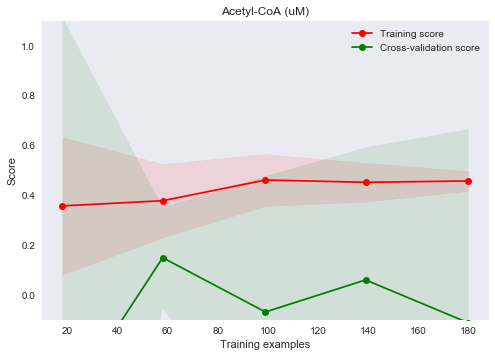

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.836e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.836e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.836e-05, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Use

HMG-CoA (uM)


Optimization Progress:   1%|▏         | 242/17030 [00:36<31:29,  8.89pipeline/s]  

Generation 1 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   2%|▏         | 365/17030 [00:58<34:19,  8.09pipeline/s]  

Generation 2 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   3%|▎         | 481/17030 [01:15<47:37,  5.79pipeline/s]  

Generation 3 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   4%|▎         | 600/17030 [01:35<33:32,  8.16pipeline/s]  

Generation 4 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   4%|▍         | 725/17030 [02:02<36:58,  7.35pipeline/s]  

Generation 5 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   5%|▍         | 845/17030 [02:15<25:44, 10.48pipeline/s]  

Generation 6 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   6%|▌         | 963/17030 [02:21<11:12, 23.90pipeline/s]

Generation 7 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   6%|▋         | 1082/17030 [02:24<08:46, 30.29pipeline/s]

Generation 8 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   7%|▋         | 1203/17030 [02:28<14:27, 18.25pipeline/s]

Generation 9 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   8%|▊         | 1326/17030 [02:33<16:26, 15.92pipeline/s]

Generation 10 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   8%|▊         | 1444/17030 [02:37<12:52, 20.17pipeline/s]

Generation 11 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:   9%|▉         | 1562/17030 [02:42<12:22, 20.84pipeline/s]

Generation 12 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  10%|▉         | 1673/17030 [02:46<17:31, 14.60pipeline/s]

Generation 13 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  11%|█         | 1799/17030 [02:51<17:09, 14.79pipeline/s]

Generation 14 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  11%|█▏        | 1923/17030 [02:55<11:42, 21.50pipeline/s]

Generation 15 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  12%|█▏        | 2046/17030 [02:58<12:33, 19.88pipeline/s]

Generation 16 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  13%|█▎        | 2158/17030 [03:01<08:49, 28.06pipeline/s]

Generation 17 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  13%|█▎        | 2280/17030 [03:04<08:54, 27.57pipeline/s]

Generation 18 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  14%|█▍        | 2400/17030 [03:09<08:24, 29.00pipeline/s]

Generation 19 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  15%|█▍        | 2522/17030 [03:13<16:00, 15.11pipeline/s]

Generation 20 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  16%|█▌        | 2643/17030 [03:17<14:32, 16.49pipeline/s]

Generation 21 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  16%|█▌        | 2764/17030 [03:22<16:47, 14.16pipeline/s]

Generation 22 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  17%|█▋        | 2885/17030 [03:25<10:34, 22.30pipeline/s]

Generation 23 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  18%|█▊        | 3004/17030 [03:29<12:13, 19.12pipeline/s]

Generation 24 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  18%|█▊        | 3124/17030 [03:32<12:38, 18.34pipeline/s]

Generation 25 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  19%|█▉        | 3245/17030 [03:36<12:55, 17.76pipeline/s]

Generation 26 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  20%|█▉        | 3367/17030 [03:40<13:53, 16.39pipeline/s]

Generation 27 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  20%|██        | 3482/17030 [03:43<13:52, 16.28pipeline/s]

Generation 28 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  21%|██        | 3595/17030 [03:44<09:25, 23.78pipeline/s]

Generation 29 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  22%|██▏       | 3715/17030 [03:48<10:19, 21.49pipeline/s]

Generation 30 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  22%|██▏       | 3829/17030 [03:51<11:29, 19.14pipeline/s]

Generation 31 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  23%|██▎       | 3953/17030 [03:54<13:08, 16.59pipeline/s]

Generation 32 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  24%|██▍       | 4069/17030 [03:58<12:37, 17.12pipeline/s]

Generation 33 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  25%|██▍       | 4188/17030 [04:00<10:51, 19.72pipeline/s]

Generation 34 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  25%|██▌       | 4301/17030 [04:04<15:21, 13.81pipeline/s]

Generation 35 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  26%|██▌       | 4419/17030 [04:07<08:59, 23.38pipeline/s]

Generation 36 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  27%|██▋       | 4538/17030 [04:10<10:32, 19.75pipeline/s]

Generation 37 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  27%|██▋       | 4664/17030 [04:13<10:13, 20.15pipeline/s]

Generation 38 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  28%|██▊       | 4783/17030 [04:15<08:33, 23.84pipeline/s]

Generation 39 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  29%|██▉       | 4901/17030 [04:19<11:13, 18.01pipeline/s]

Generation 40 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  29%|██▉       | 5022/17030 [04:22<11:50, 16.90pipeline/s]

Generation 41 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  30%|███       | 5140/17030 [04:25<08:32, 23.19pipeline/s]

Generation 42 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  31%|███       | 5255/17030 [04:28<09:24, 20.88pipeline/s]

Generation 43 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  32%|███▏      | 5374/17030 [04:31<10:09, 19.11pipeline/s]

Generation 44 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  32%|███▏      | 5497/17030 [04:35<09:01, 21.29pipeline/s]

Generation 45 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  33%|███▎      | 5616/17030 [04:37<08:38, 22.02pipeline/s]

Generation 46 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  34%|███▎      | 5734/17030 [04:40<08:28, 22.21pipeline/s]

Generation 47 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  34%|███▍      | 5853/17030 [04:43<07:36, 24.46pipeline/s]

Generation 48 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  35%|███▌      | 5978/17030 [04:47<14:09, 13.01pipeline/s]

Generation 49 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  36%|███▌      | 6101/17030 [04:49<09:19, 19.54pipeline/s]

Generation 50 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  37%|███▋      | 6222/17030 [04:52<09:50, 18.32pipeline/s]

Generation 51 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  37%|███▋      | 6344/17030 [04:55<10:05, 17.66pipeline/s]

Generation 52 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  38%|███▊      | 6465/17030 [04:59<11:12, 15.71pipeline/s]

Generation 53 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  39%|███▊      | 6581/17030 [05:03<11:45, 14.81pipeline/s]

Generation 54 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  39%|███▉      | 6702/17030 [05:06<12:15, 14.04pipeline/s]

Generation 55 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  40%|████      | 6823/17030 [05:10<11:36, 14.66pipeline/s]

Generation 56 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  41%|████      | 6938/17030 [05:13<10:20, 16.26pipeline/s]

Generation 57 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  41%|████▏     | 7055/17030 [05:16<07:36, 21.87pipeline/s]

Generation 58 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  42%|████▏     | 7174/17030 [05:19<12:00, 13.67pipeline/s]

Generation 59 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  43%|████▎     | 7291/17030 [05:23<07:43, 21.00pipeline/s]

Generation 60 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  44%|████▎     | 7412/17030 [05:26<10:31, 15.23pipeline/s]

Generation 61 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  44%|████▍     | 7538/17030 [05:29<09:25, 16.79pipeline/s]

Generation 62 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  45%|████▍     | 7654/17030 [05:33<10:26, 14.97pipeline/s]

Generation 63 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  46%|████▌     | 7774/17030 [05:35<08:17, 18.59pipeline/s]

Generation 64 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  46%|████▋     | 7894/17030 [05:37<09:30, 16.01pipeline/s]

Generation 65 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  47%|████▋     | 8013/17030 [05:41<12:23, 12.13pipeline/s]

Generation 66 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  48%|████▊     | 8133/17030 [05:45<08:09, 18.17pipeline/s]

Generation 67 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  48%|████▊     | 8253/17030 [05:49<13:51, 10.56pipeline/s]

Generation 68 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  49%|████▉     | 8375/17030 [05:52<13:55, 10.35pipeline/s]

Generation 69 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  50%|████▉     | 8497/17030 [05:54<09:21, 15.20pipeline/s]

Generation 70 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  51%|█████     | 8619/17030 [05:57<06:39, 21.04pipeline/s]

Generation 71 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  51%|█████▏    | 8737/17030 [06:01<06:38, 20.79pipeline/s]

Generation 72 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  52%|█████▏    | 8862/17030 [06:06<09:19, 14.61pipeline/s]

Generation 73 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  53%|█████▎    | 8981/17030 [06:09<08:49, 15.20pipeline/s]

Generation 74 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  53%|█████▎    | 9106/17030 [06:14<09:19, 14.17pipeline/s]

Generation 75 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  54%|█████▍    | 9228/17030 [06:15<04:52, 26.70pipeline/s]

Generation 76 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  55%|█████▍    | 9348/17030 [06:18<04:26, 28.85pipeline/s]

Generation 77 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  56%|█████▌    | 9470/17030 [06:22<05:44, 21.96pipeline/s]

Generation 78 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  56%|█████▋    | 9594/17030 [06:27<11:35, 10.70pipeline/s]

Generation 79 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  57%|█████▋    | 9711/17030 [06:29<05:53, 20.71pipeline/s]

Generation 80 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  58%|█████▊    | 9835/17030 [06:32<08:59, 13.34pipeline/s]

Generation 81 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  58%|█████▊    | 9957/17030 [06:34<05:13, 22.54pipeline/s]

Generation 82 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  59%|█████▉    | 10076/17030 [06:37<06:09, 18.82pipeline/s]

Generation 83 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  60%|█████▉    | 10199/17030 [06:39<05:13, 21.78pipeline/s]

Generation 84 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  61%|██████    | 10319/17030 [06:44<06:25, 17.40pipeline/s]

Generation 85 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  61%|██████▏   | 10435/17030 [06:46<07:08, 15.40pipeline/s]

Generation 86 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  62%|██████▏   | 10560/17030 [06:50<06:59, 15.43pipeline/s]

Generation 87 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  63%|██████▎   | 10682/17030 [06:54<09:13, 11.46pipeline/s]

Generation 88 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  63%|██████▎   | 10801/17030 [06:56<06:16, 16.55pipeline/s]

Generation 89 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  64%|██████▍   | 10925/17030 [07:01<08:17, 12.28pipeline/s]

Generation 90 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  65%|██████▍   | 11046/17030 [07:05<12:33,  7.94pipeline/s]

Generation 91 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  66%|██████▌   | 11168/17030 [07:09<10:33,  9.25pipeline/s]

Generation 92 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  66%|██████▋   | 11289/17030 [07:11<07:22, 12.98pipeline/s]

Generation 93 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  67%|██████▋   | 11408/17030 [07:16<06:38, 14.11pipeline/s]

Generation 94 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  68%|██████▊   | 11534/17030 [07:19<05:14, 17.48pipeline/s]

Generation 95 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  68%|██████▊   | 11652/17030 [07:21<04:47, 18.72pipeline/s]

Generation 96 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  69%|██████▉   | 11775/17030 [07:25<04:14, 20.63pipeline/s]

Generation 97 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  70%|██████▉   | 11894/17030 [07:28<05:56, 14.41pipeline/s]

Generation 98 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  71%|███████   | 12012/17030 [07:32<05:41, 14.68pipeline/s]

Generation 99 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  71%|███████▏  | 12136/17030 [07:35<03:10, 25.70pipeline/s]

Generation 100 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  72%|███████▏  | 12259/17030 [07:41<08:26,  9.43pipeline/s]

Generation 101 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  73%|███████▎  | 12378/17030 [07:46<08:15,  9.39pipeline/s]

Generation 102 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  73%|███████▎  | 12494/17030 [07:49<05:18, 14.23pipeline/s]

Generation 103 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  74%|███████▍  | 12617/17030 [07:52<03:30, 20.98pipeline/s]

Generation 104 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  75%|███████▍  | 12738/17030 [07:55<04:40, 15.32pipeline/s]

Generation 105 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  76%|███████▌  | 12858/17030 [07:57<03:13, 21.56pipeline/s]

Generation 106 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  76%|███████▌  | 12983/17030 [08:02<06:56,  9.71pipeline/s]

Generation 107 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  77%|███████▋  | 13102/17030 [08:04<05:01, 13.03pipeline/s]

Generation 108 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  78%|███████▊  | 13228/17030 [08:08<03:01, 20.92pipeline/s]

Generation 109 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  78%|███████▊  | 13350/17030 [08:11<03:48, 16.12pipeline/s]

Generation 110 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  79%|███████▉  | 13470/17030 [08:13<03:15, 18.21pipeline/s]

Generation 111 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  80%|███████▉  | 13592/17030 [08:15<02:47, 20.54pipeline/s]

Generation 112 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  81%|████████  | 13712/17030 [08:18<04:42, 11.73pipeline/s]

Generation 113 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  81%|████████  | 13831/17030 [08:22<03:51, 13.82pipeline/s]

Generation 114 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  82%|████████▏ | 13952/17030 [08:25<04:19, 11.84pipeline/s]

Generation 115 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  83%|████████▎ | 14074/17030 [08:28<03:02, 16.22pipeline/s]

Generation 116 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  83%|████████▎ | 14199/17030 [08:32<03:24, 13.82pipeline/s]

Generation 117 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  84%|████████▍ | 14321/17030 [08:36<03:07, 14.44pipeline/s]

Generation 118 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  85%|████████▍ | 14443/17030 [08:40<03:40, 11.72pipeline/s]

Generation 119 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  86%|████████▌ | 14566/17030 [08:43<04:50,  8.49pipeline/s]

Generation 120 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  86%|████████▌ | 14688/17030 [08:47<03:09, 12.33pipeline/s]

Generation 121 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  87%|████████▋ | 14811/17030 [08:52<03:17, 11.22pipeline/s]

Generation 122 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  88%|████████▊ | 14934/17030 [08:56<03:29, 10.00pipeline/s]

Generation 123 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  88%|████████▊ | 15056/17030 [08:59<02:05, 15.71pipeline/s]

Generation 124 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  89%|████████▉ | 15181/17030 [09:00<02:11, 14.09pipeline/s]

Generation 125 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  90%|████████▉ | 15303/17030 [09:04<01:38, 17.58pipeline/s]

Generation 126 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  91%|█████████ | 15427/17030 [09:07<01:39, 16.17pipeline/s]

Generation 127 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  91%|█████████▏| 15547/17030 [09:09<01:19, 18.63pipeline/s]

Generation 128 - Current best internal CV score: 0.00011380667959142894


Optimization Progress:  92%|█████████▏| 15670/17030 [09:12<01:01, 22.23pipeline/s]

Generation 129 - Current best internal CV score: 0.00011380667959142894


Generation 130 - Current best internal CV score: 0.00011380667959142894

Best pipeline: LinearSVR(input_matrix, LinearSVR__C=0.1, LinearSVR__dual=True, LinearSVR__epsilon=0.1, LinearSVR__loss=DEFAULT, LinearSVR__tol=0.01)
HMG-CoA (uM)


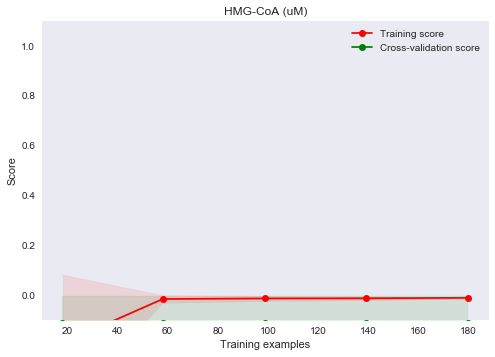

IPP/DMAPP (uM)


Optimization Progress:   1%|▏         | 242/17030 [00:31<31:23,  8.92pipeline/s]  

Generation 1 - Current best internal CV score: 0.11476788945449712


Optimization Progress:   2%|▏         | 365/17030 [01:00<31:49,  8.73pipeline/s]  

Generation 2 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   3%|▎         | 488/17030 [01:34<47:05,  5.86pipeline/s]  

Generation 3 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   4%|▎         | 604/17030 [02:00<47:55,  5.71pipeline/s]  

Generation 4 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   4%|▍         | 722/17030 [02:36<46:29,  5.85pipeline/s]  

Generation 5 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   5%|▍         | 845/17030 [03:08<35:49,  7.53pipeline/s]  

Generation 6 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   6%|▌         | 964/17030 [03:49<50:24,  5.31pipeline/s]  

Generation 7 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   6%|▋         | 1083/17030 [04:19<39:17,  6.76pipeline/s]  

Generation 8 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   7%|▋         | 1197/17030 [04:41<24:47, 10.64pipeline/s]  

Generation 9 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   8%|▊         | 1313/17030 [05:09<39:04,  6.71pipeline/s]   

Generation 10 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   8%|▊         | 1434/17030 [05:46<51:51,  5.01pipeline/s]  

Generation 11 - Current best internal CV score: 0.11465897237976246


Optimization Progress:   9%|▉         | 1555/17030 [06:30<1:04:12,  4.02pipeline/s]

Generation 12 - Current best internal CV score: 0.11465897237976246


Optimization Progress:  10%|▉         | 1680/17030 [07:31<1:00:04,  4.26pipeline/s]

Generation 13 - Current best internal CV score: 0.11465897237976246


Optimization Progress:  11%|█         | 1797/17030 [08:18<1:07:45,  3.75pipeline/s]

Generation 14 - Current best internal CV score: 0.11149600885226371


Optimization Progress:  11%|█         | 1915/17030 [09:25<50:56,  4.95pipeline/s]  

Generation 15 - Current best internal CV score: 0.11149600885226371


Optimization Progress:  12%|█▏        | 2030/17030 [10:05<1:15:25,  3.31pipeline/s]

Generation 16 - Current best internal CV score: 0.11149600885226371


Optimization Progress:  13%|█▎        | 2154/17030 [10:46<48:24,  5.12pipeline/s]  

Generation 17 - Current best internal CV score: 0.11149600885226371


Optimization Progress:  13%|█▎        | 2274/17030 [11:29<1:02:03,  3.96pipeline/s]

Generation 18 - Current best internal CV score: 0.11149600885226371


Optimization Progress:  14%|█▍        | 2392/17030 [12:13<51:48,  4.71pipeline/s]  

Generation 19 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  15%|█▍        | 2506/17030 [12:56<55:04,  4.39pipeline/s]   

Generation 20 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  15%|█▌        | 2627/17030 [13:46<1:00:49,  3.95pipeline/s]

Generation 21 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  16%|█▌        | 2743/17030 [14:39<58:31,  4.07pipeline/s]   

Generation 22 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  17%|█▋        | 2859/17030 [15:17<56:14,  4.20pipeline/s]   

Generation 23 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  17%|█▋        | 2971/17030 [16:10<1:32:57,  2.52pipeline/s] 

Generation 24 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  18%|█▊        | 3086/17030 [17:00<52:56,  4.39pipeline/s]  

Generation 25 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  19%|█▉        | 3203/17030 [17:44<1:14:09,  3.11pipeline/s] 

Generation 26 - Current best internal CV score: 0.10739380693523201


Optimization Progress:  20%|█▉        | 3323/17030 [18:25<54:38,  4.18pipeline/s]  

Generation 27 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  20%|██        | 3444/17030 [19:02<54:58,  4.12pipeline/s]  

Generation 28 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  21%|██        | 3554/17030 [19:35<1:08:51,  3.26pipeline/s]

Generation 29 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  22%|██▏       | 3670/17030 [20:07<43:34,  5.11pipeline/s]  

Generation 30 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  22%|██▏       | 3780/17030 [20:33<35:05,  6.29pipeline/s]  

Generation 31 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  23%|██▎       | 3884/17030 [20:54<35:41,  6.14pipeline/s]  

Generation 32 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  23%|██▎       | 3986/17030 [21:17<42:43,  5.09pipeline/s]  

Generation 33 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  24%|██▍       | 4095/17030 [21:36<38:39,  5.58pipeline/s]  

Generation 34 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  25%|██▍       | 4195/17030 [21:53<34:41,  6.17pipeline/s]  

Generation 35 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  25%|██▌       | 4293/17030 [22:08<32:37,  6.51pipeline/s]  

Generation 36 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  26%|██▌       | 4392/17030 [22:23<26:25,  7.97pipeline/s]  

Generation 37 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  26%|██▋       | 4489/17030 [22:34<28:22,  7.37pipeline/s]  

Generation 38 - Current best internal CV score: 0.10265969350506825


Optimization Progress:  27%|██▋       | 4587/17030 [22:46<24:40,  8.41pipeline/s]  

Generation 39 - Current best internal CV score: 0.10265969350506739


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=7.694e-05, previous alpha=4.798e-05, with an active set of 7 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=2.392e-03, previous alpha=1.476e-06, with an active set of 10 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=6.684e-04, previous alpha=1.281e-07, with an


Best pipeline: LassoLarsCV(PolynomialFeatures(LassoLarsCV(MaxAbsScaler(input_matrix), LassoLarsCV__normalize=True), PolynomialFeatures__degree=2, PolynomialFeatures__include_bias=False, PolynomialFeatures__interaction_only=DEFAULT), LassoLarsCV__normalize=DEFAULT)


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=2.474e-02, previous alpha=3.128e-05, with an active set of 11 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=6.897e-03, previous alpha=1.971e-05, with an active set of 16 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=2.966e-03, previous alpha=7.649e-05, with a

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=5.237e-04, previous alpha=6.975e-05, with an active set of 11 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=2.873e-03, previous alpha=5.558e-05, with an active set of 12 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=3.327e-04, previous alpha=3.599e-05, with a

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.470e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.709e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.692e-03, previous alpha=1.580e-03, with an active set of 5 regressors.
  Converg

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.239e-04, previous alpha=5.796e-05, with an active set of 11 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=6.107e-04, previous alpha=4.681e-05, with an active set of 13 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=1.624e-04, previous alpha=1.081e-04, with a

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=3.770e-03, previous alpha=1.276e-05, with an active set of 15 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=1.826e-03, previous alpha=2.648e-05, with an active set of 12 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=9.081e-03, previous alpha=4.022e-06, with a

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=1.809e-03, previous alpha=3.090e-05, with an active set of 13 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=3.688e-03, previous alpha=4.521e-05, with an active set of 11 regressors.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=1.958e-03, previous alpha=4.388e-05, with a

IPPDMAPP (uM)


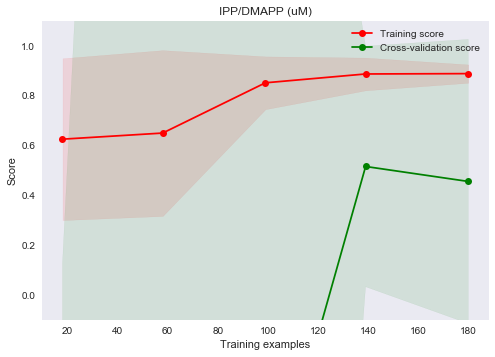

/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.927e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.356e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.927e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.461e-03, previous alpha=1.256e-03, with an active set of 5 regressors.
  Converg

Intracellular Mevalonate (uM)


Optimization Progress:   1%|▏         | 232/17030 [00:54<36:40,  7.63pipeline/s]  

Generation 1 - Current best internal CV score: 0.000599119464603647


Optimization Progress:   2%|▏         | 341/17030 [01:22<25:40, 10.83pipeline/s]  

Generation 2 - Current best internal CV score: 0.0005669557864563479


Optimization Progress:   3%|▎         | 446/17030 [01:38<30:43,  9.00pipeline/s]  

Generation 3 - Current best internal CV score: 0.0005272704479917016


Optimization Progress:   3%|▎         | 556/17030 [01:57<35:57,  7.63pipeline/s]  

Generation 4 - Current best internal CV score: 0.0005272704479917016


Optimization Progress:   4%|▍         | 661/17030 [02:17<30:43,  8.88pipeline/s]  

Generation 5 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   4%|▍         | 765/17030 [02:28<22:39, 11.96pipeline/s]  

Generation 6 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   5%|▌         | 867/17030 [02:43<48:18,  5.58pipeline/s]  

Generation 7 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   6%|▌         | 962/17030 [02:56<27:52,  9.61pipeline/s]  

Generation 8 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   6%|▌         | 1059/17030 [03:09<39:53,  6.67pipeline/s] 

Generation 9 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   7%|▋         | 1139/17030 [03:19<19:45, 13.41pipeline/s]  

Generation 10 - Current best internal CV score: 0.0005203097506327673


Optimization Progress:   7%|▋         | 1230/17030 [03:31<24:44, 10.65pipeline/s]  

Generation 11 - Current best internal CV score: 0.0005171237779571973


Optimization Progress:   8%|▊         | 1321/17030 [03:46<25:58, 10.08pipeline/s]  

Generation 12 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:   8%|▊         | 1403/17030 [04:01<32:03,  8.12pipeline/s]  

Generation 13 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:   9%|▉         | 1491/17030 [04:18<20:43, 12.50pipeline/s]  

Generation 14 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:   9%|▉         | 1577/17030 [04:39<36:49,  6.99pipeline/s]  

Generation 15 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  10%|▉         | 1663/17030 [04:59<28:04,  9.12pipeline/s]  

Generation 16 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  10%|█         | 1758/17030 [05:22<43:06,  5.90pipeline/s]  

Generation 17 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  11%|█         | 1840/17030 [05:37<33:52,  7.47pipeline/s]  

Generation 18 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  11%|█▏        | 1924/17030 [05:56<33:52,  7.43pipeline/s]  

Generation 19 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  12%|█▏        | 2016/17030 [06:15<25:14,  9.91pipeline/s]  

Generation 20 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  12%|█▏        | 2092/17030 [06:34<22:57, 10.85pipeline/s]  

Generation 21 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  13%|█▎        | 2174/17030 [06:50<29:20,  8.44pipeline/s]  

Generation 22 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  13%|█▎        | 2265/17030 [07:13<39:07,  6.29pipeline/s]  

Generation 23 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  14%|█▍        | 2366/17030 [07:36<24:37,  9.92pipeline/s]  

Generation 24 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  14%|█▍        | 2452/17030 [07:56<27:25,  8.86pipeline/s]  

Generation 25 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  15%|█▍        | 2542/17030 [08:15<21:33, 11.20pipeline/s]  

Generation 26 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  15%|█▌        | 2632/17030 [08:38<37:58,  6.32pipeline/s]  

Generation 27 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  16%|█▌        | 2717/17030 [08:55<20:54, 11.41pipeline/s]  

Generation 28 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  16%|█▋        | 2796/17030 [09:13<29:50,  7.95pipeline/s]  

Generation 29 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  17%|█▋        | 2877/17030 [09:30<26:48,  8.80pipeline/s]  

Generation 30 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  17%|█▋        | 2963/17030 [09:45<25:55,  9.04pipeline/s]  

Generation 31 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  18%|█▊        | 3046/17030 [10:00<32:19,  7.21pipeline/s]  

Generation 32 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  18%|█▊        | 3134/17030 [10:18<26:39,  8.69pipeline/s]  

Generation 33 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  19%|█▉        | 3219/17030 [10:35<22:12, 10.36pipeline/s]  

Generation 34 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  19%|█▉        | 3310/17030 [10:56<19:31, 11.71pipeline/s]  

Generation 35 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  20%|█▉        | 3399/17030 [11:16<26:23,  8.61pipeline/s]  

Generation 36 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  21%|██        | 3494/17030 [11:32<24:33,  9.19pipeline/s]  

Generation 37 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  21%|██        | 3575/17030 [11:51<44:33,  5.03pipeline/s]  

Generation 38 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  22%|██▏       | 3662/17030 [12:13<27:34,  8.08pipeline/s]  

Generation 39 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  22%|██▏       | 3753/17030 [12:34<27:30,  8.04pipeline/s]  

Generation 40 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  23%|██▎       | 3834/17030 [12:49<26:00,  8.45pipeline/s]  

Generation 41 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  23%|██▎       | 3915/17030 [13:08<33:34,  6.51pipeline/s]  

Generation 42 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  23%|██▎       | 3997/17030 [13:27<34:54,  6.22pipeline/s]  

Generation 43 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  24%|██▍       | 4090/17030 [13:44<20:07, 10.71pipeline/s]  

Generation 44 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  25%|██▍       | 4186/17030 [14:00<25:14,  8.48pipeline/s]  

Generation 45 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  25%|██▌       | 4275/17030 [14:16<16:43, 12.71pipeline/s]  

Generation 46 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  26%|██▌       | 4360/17030 [14:35<25:11,  8.38pipeline/s]  

Generation 47 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  26%|██▌       | 4451/17030 [14:52<16:38, 12.60pipeline/s]  

Generation 48 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  27%|██▋       | 4538/17030 [15:06<17:21, 11.99pipeline/s]  

Generation 49 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  27%|██▋       | 4631/17030 [15:24<24:56,  8.28pipeline/s]  

Generation 50 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  28%|██▊       | 4723/17030 [15:40<26:19,  7.79pipeline/s]  

Generation 51 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  28%|██▊       | 4816/17030 [15:58<31:58,  6.37pipeline/s]  

Generation 52 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  29%|██▉       | 4906/17030 [16:14<18:44, 10.78pipeline/s]  

Generation 53 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  29%|██▉       | 4978/17030 [16:27<20:29,  9.80pipeline/s]

Generation 54 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  30%|██▉       | 5062/17030 [16:39<09:32, 20.91pipeline/s]  

Generation 55 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  30%|███       | 5150/17030 [16:55<23:20,  8.48pipeline/s]  

Generation 56 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  31%|███       | 5228/17030 [17:09<24:37,  7.99pipeline/s]  

Generation 57 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  31%|███       | 5312/17030 [17:27<17:01, 11.47pipeline/s]

Generation 58 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  32%|███▏      | 5396/17030 [17:41<20:32,  9.44pipeline/s]

Generation 59 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  32%|███▏      | 5491/17030 [17:59<19:26,  9.89pipeline/s]

Generation 60 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  33%|███▎      | 5586/17030 [18:17<17:23, 10.97pipeline/s]

Generation 61 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  33%|███▎      | 5665/17030 [18:34<20:55,  9.05pipeline/s]

Generation 62 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  34%|███▎      | 5737/17030 [18:48<19:52,  9.47pipeline/s]  

Generation 63 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  34%|███▍      | 5814/17030 [19:02<23:41,  7.89pipeline/s]

Generation 64 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  35%|███▍      | 5906/17030 [19:23<30:29,  6.08pipeline/s]  

Generation 65 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  35%|███▌      | 5993/17030 [19:42<35:33,  5.17pipeline/s]  

Generation 66 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  36%|███▌      | 6081/17030 [20:01<17:01, 10.72pipeline/s]  

Generation 67 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  36%|███▌      | 6159/17030 [20:15<22:46,  7.96pipeline/s]  

Generation 68 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  37%|███▋      | 6253/17030 [20:35<19:56,  9.00pipeline/s]

Generation 69 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  37%|███▋      | 6345/17030 [20:52<21:00,  8.47pipeline/s]

Generation 70 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  38%|███▊      | 6434/17030 [21:12<28:02,  6.30pipeline/s]

Generation 71 - Current best internal CV score: 0.0005148224734659406


Optimization Progress:  38%|███▊      | 6520/17030 [21:29<18:08,  9.65pipeline/s]

Generation 72 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  39%|███▉      | 6607/17030 [21:47<16:42, 10.39pipeline/s]

Generation 73 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  39%|███▉      | 6691/17030 [22:04<20:31,  8.40pipeline/s]

Generation 74 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  40%|███▉      | 6770/17030 [22:18<25:10,  6.79pipeline/s]  

Generation 75 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  40%|████      | 6851/17030 [22:29<17:06,  9.92pipeline/s]

Generation 76 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  41%|████      | 6936/17030 [22:44<21:32,  7.81pipeline/s]

Generation 77 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  41%|████▏     | 7027/17030 [23:10<21:18,  7.82pipeline/s]

Generation 78 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  42%|████▏     | 7116/17030 [23:28<19:33,  8.45pipeline/s]

Generation 79 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  42%|████▏     | 7199/17030 [23:44<15:55, 10.29pipeline/s]

Generation 80 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  43%|████▎     | 7282/17030 [24:03<24:30,  6.63pipeline/s]

Generation 81 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  43%|████▎     | 7360/17030 [24:17<20:26,  7.88pipeline/s]

Generation 82 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  44%|████▍     | 7454/17030 [24:35<20:52,  7.64pipeline/s]

Generation 83 - Current best internal CV score: 0.0005039417772389942


Optimization Progress:  44%|████▍     | 7544/17030 [24:52<22:23,  7.06pipeline/s]

Generation 84 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  45%|████▍     | 7632/17030 [25:07<20:17,  7.72pipeline/s]

Generation 85 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  45%|████▌     | 7717/17030 [25:22<15:34,  9.97pipeline/s]

Generation 86 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  46%|████▌     | 7800/17030 [25:33<18:23,  8.37pipeline/s]

Generation 87 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  46%|████▋     | 7887/17030 [25:48<15:06, 10.08pipeline/s]

Generation 88 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  47%|████▋     | 7975/17030 [26:04<20:34,  7.34pipeline/s]

Generation 89 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  47%|████▋     | 8072/17030 [26:22<19:20,  7.72pipeline/s]

Generation 90 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  48%|████▊     | 8153/17030 [26:35<13:58, 10.58pipeline/s]

Generation 91 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  48%|████▊     | 8243/17030 [26:52<19:04,  7.68pipeline/s]

Generation 92 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  49%|████▉     | 8332/17030 [27:08<18:55,  7.66pipeline/s]

Generation 93 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  49%|████▉     | 8412/17030 [27:20<18:38,  7.71pipeline/s]

Generation 94 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  50%|████▉     | 8500/17030 [27:40<13:09, 10.80pipeline/s]

Generation 95 - Current best internal CV score: 0.000502662287490285


Optimization Progress:  50%|█████     | 8595/17030 [27:58<14:55,  9.42pipeline/s]

Generation 96 - Current best internal CV score: 0.0005024791704461172


Optimization Progress:  51%|█████     | 8686/17030 [28:17<23:17,  5.97pipeline/s]

Generation 97 - Current best internal CV score: 0.0005024791704461172


Optimization Progress:  52%|█████▏    | 8772/17030 [28:37<18:32,  7.42pipeline/s]

Generation 98 - Current best internal CV score: 0.0005024791704461172


Optimization Progress:  52%|█████▏    | 8868/17030 [28:52<18:30,  7.35pipeline/s]

Generation 99 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  53%|█████▎    | 8943/17030 [29:05<22:30,  5.99pipeline/s]

Generation 100 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  53%|█████▎    | 9027/17030 [29:22<19:16,  6.92pipeline/s]

Generation 101 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  54%|█████▎    | 9117/17030 [29:43<13:30,  9.76pipeline/s]

Generation 102 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  54%|█████▍    | 9204/17030 [29:56<16:00,  8.15pipeline/s]

Generation 103 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  55%|█████▍    | 9292/17030 [30:13<13:29,  9.56pipeline/s]

Generation 104 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  55%|█████▌    | 9389/17030 [30:28<14:38,  8.69pipeline/s]

Generation 105 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  56%|█████▌    | 9480/17030 [30:48<14:40,  8.57pipeline/s]

Generation 106 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  56%|█████▌    | 9572/17030 [31:07<14:04,  8.83pipeline/s]

Generation 107 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  57%|█████▋    | 9659/17030 [31:25<10:53, 11.28pipeline/s]

Generation 108 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  57%|█████▋    | 9741/17030 [31:42<12:57,  9.37pipeline/s]

Generation 109 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  58%|█████▊    | 9821/17030 [31:53<14:20,  8.38pipeline/s]

Generation 110 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  58%|█████▊    | 9909/17030 [32:10<15:42,  7.55pipeline/s]

Generation 111 - Current best internal CV score: 0.0005008849387939929


Optimization Progress:  59%|█████▊    | 9997/17030 [32:30<12:25,  9.44pipeline/s]

Generation 112 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  59%|█████▉    | 10083/17030 [32:47<21:45,  5.32pipeline/s]

Generation 113 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  60%|█████▉    | 10168/17030 [33:07<16:11,  7.06pipeline/s]

Generation 114 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  60%|██████    | 10257/17030 [33:23<20:55,  5.40pipeline/s]

Generation 115 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  61%|██████    | 10343/17030 [33:42<13:10,  8.46pipeline/s]

Generation 116 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  61%|██████▏   | 10432/17030 [34:03<13:37,  8.07pipeline/s]

Generation 117 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  62%|██████▏   | 10525/17030 [34:20<16:34,  6.54pipeline/s]

Generation 118 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  62%|██████▏   | 10617/17030 [34:41<17:27,  6.12pipeline/s]

Generation 119 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  63%|██████▎   | 10701/17030 [34:59<12:33,  8.40pipeline/s]

Generation 120 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  63%|██████▎   | 10785/17030 [35:15<09:25, 11.04pipeline/s]

Generation 121 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  64%|██████▍   | 10865/17030 [35:31<15:58,  6.43pipeline/s]

Generation 122 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  64%|██████▍   | 10960/17030 [35:51<15:42,  6.44pipeline/s]

Generation 123 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  65%|██████▍   | 11042/17030 [36:09<14:07,  7.07pipeline/s]

Generation 124 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  65%|██████▌   | 11122/17030 [36:25<14:35,  6.75pipeline/s]

Generation 125 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  66%|██████▌   | 11214/17030 [36:41<13:05,  7.41pipeline/s]

Generation 126 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  66%|██████▋   | 11295/17030 [36:54<07:20, 13.01pipeline/s]

Generation 127 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  67%|██████▋   | 11386/17030 [37:12<10:02,  9.37pipeline/s]

Generation 128 - Current best internal CV score: 0.0005003625645318897


Optimization Progress:  67%|██████▋   | 11476/17030 [37:28<12:57,  7.14pipeline/s]

Generation 129 - Current best internal CV score: 0.0004952805053835381


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Generation 130 - Current best internal CV score: 0.0004952805053835381

Best pipeline: RidgeCV(SelectPercentile(GradientBoostingRegressor(RidgeCV(VarianceThreshold(input_matrix, VarianceThreshold__threshold=0.8)), GradientBoostingRegressor__alpha=DEFAULT, GradientBoostingRegressor__learning_rate=0.001, GradientBoostingRegressor__loss=huber, GradientBoostingRegressor__max_depth=DEFAULT, GradientBoostingRegressor__max_features=0.4, GradientBoostingRegressor__min_samples_leaf=20, GradientBoostingRegressor__min_samples_split=5, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.4), SelectPercentile__percentile=75))


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0] are constant.
  UserWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/uni

Intracellular Mevalonate (uM)


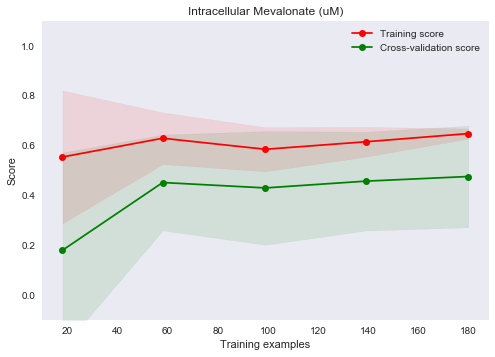

Limonene g/L


Optimization Progress:   1%|▏         | 229/17030 [00:47<36:49,  7.60pipeline/s]  

Generation 1 - Current best internal CV score: 3.9582644351301124e-06


Optimization Progress:   2%|▏         | 345/17030 [01:20<43:16,  6.43pipeline/s]  

Generation 2 - Current best internal CV score: 3.9582644351301124e-06


Optimization Progress:   3%|▎         | 468/17030 [02:09<34:10,  8.08pipeline/s]  

Generation 3 - Current best internal CV score: 3.6431325054475387e-06


Optimization Progress:   3%|▎         | 585/17030 [02:46<55:49,  4.91pipeline/s]  

Generation 4 - Current best internal CV score: 3.6431325054475387e-06


Optimization Progress:   4%|▍         | 701/17030 [03:36<54:31,  4.99pipeline/s]  

Generation 5 - Current best internal CV score: 3.6431325054475387e-06


Optimization Progress:   5%|▍         | 821/17030 [04:33<52:39,  5.13pipeline/s]   

Generation 6 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   6%|▌         | 940/17030 [05:13<1:20:50,  3.32pipeline/s] 

Generation 7 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   6%|▌         | 1063/17030 [05:53<47:28,  5.61pipeline/s]  

Generation 8 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   7%|▋         | 1191/17030 [06:25<45:08,  5.85pipeline/s]  

Generation 9 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   8%|▊         | 1311/17030 [07:08<50:41,  5.17pipeline/s]  

Generation 10 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   8%|▊         | 1431/17030 [07:49<1:01:32,  4.22pipeline/s] 

Generation 11 - Current best internal CV score: 3.2400341376483317e-06


Optimization Progress:   9%|▉         | 1552/17030 [08:38<41:21,  6.24pipeline/s]   

Generation 12 - Current best internal CV score: 3.2400341376483317e-06



Best pipeline: ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=DEFAULT, ExtraTreesRegressor__max_features=0.75, ExtraTreesRegressor__min_samples_leaf=1, ExtraTreesRegressor__min_samples_split=16, ExtraTreesRegressor__n_estimators=DEFAULT)
Limonene gL


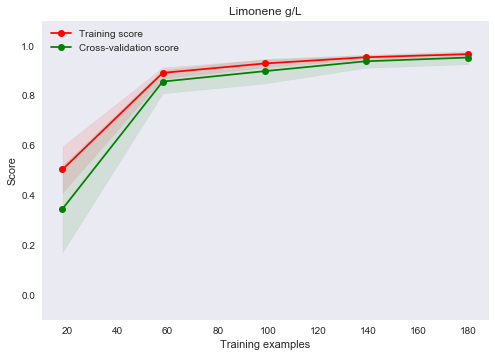

Mev-P (uM)


Optimization Progress:   1%|▏         | 232/17030 [00:32<31:56,  8.76pipeline/s]  

Generation 1 - Current best internal CV score: 0.023696674862724594


Optimization Progress:   2%|▏         | 344/17030 [01:03<35:47,  7.77pipeline/s]  

Generation 2 - Current best internal CV score: 0.023696674862724594


Optimization Progress:   3%|▎         | 463/17030 [01:53<1:25:20,  3.24pipeline/s]

Generation 3 - Current best internal CV score: 0.023696674862724594


Optimization Progress:   3%|▎         | 583/17030 [02:58<1:04:58,  4.22pipeline/s]

Generation 4 - Current best internal CV score: 0.021213521807359775


Optimization Progress:   4%|▍         | 712/17030 [03:56<53:51,  5.05pipeline/s]  

Generation 5 - Current best internal CV score: 0.021213521807359775


Optimization Progress:   5%|▍         | 838/17030 [05:19<1:22:27,  3.27pipeline/s]

Generation 6 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   6%|▌         | 961/17030 [06:35<1:14:26,  3.60pipeline/s]

Generation 7 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   6%|▋         | 1084/17030 [07:41<49:27,  5.37pipeline/s]  

Generation 8 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   7%|▋         | 1205/17030 [08:44<1:05:14,  4.04pipeline/s]

Generation 9 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   8%|▊         | 1325/17030 [09:23<45:12,  5.79pipeline/s]  

Generation 10 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   8%|▊         | 1447/17030 [10:29<58:18,  4.45pipeline/s]  

Generation 11 - Current best internal CV score: 0.019904462321667708


Optimization Progress:   9%|▉         | 1572/17030 [11:24<49:20,  5.22pipeline/s]  

Generation 12 - Current best internal CV score: 0.019904462321667708


Optimization Progress:  10%|▉         | 1691/17030 [12:10<54:13,  4.72pipeline/s]   

Generation 13 - Current best internal CV score: 0.019904462321667708


Optimization Progress:  11%|█         | 1813/17030 [12:48<52:57,  4.79pipeline/s]  

Generation 14 - Current best internal CV score: 0.019904462321667708


Optimization Progress:  11%|█▏        | 1932/17030 [13:17<39:57,  6.30pipeline/s]  

Generation 15 - Current best internal CV score: 0.019904462321667708


Optimization Progress:  12%|█▏        | 2055/17030 [13:48<42:53,  5.82pipeline/s]   

Generation 16 - Current best internal CV score: 0.019904462321667708


Optimization Progress:  13%|█▎        | 2176/17030 [14:18<49:38,  4.99pipeline/s]   

Generation 17 - Current best internal CV score: 0.019859333980125824


Optimization Progress:  13%|█▎        | 2294/17030 [14:45<36:29,  6.73pipeline/s]  

Generation 18 - Current best internal CV score: 0.019859333980125824


Optimization Progress:  14%|█▍        | 2419/17030 [15:16<41:13,  5.91pipeline/s]  

Generation 19 - Current best internal CV score: 0.01983957776918317


Optimization Progress:  15%|█▍        | 2541/17030 [15:46<45:13,  5.34pipeline/s]  

Generation 20 - Current best internal CV score: 0.019829184993509663


Optimization Progress:  16%|█▌        | 2665/17030 [16:18<43:48,  5.47pipeline/s]  

Generation 21 - Current best internal CV score: 0.019829184993509663


Optimization Progress:  16%|█▋        | 2791/17030 [16:50<38:01,  6.24pipeline/s]  

Generation 22 - Current best internal CV score: 0.019829184993509663


Optimization Progress:  17%|█▋        | 2919/17030 [17:22<42:15,  5.57pipeline/s]  

Generation 23 - Current best internal CV score: 0.019829184993509663


Optimization Progress:  18%|█▊        | 3043/17030 [17:54<40:39,  5.73pipeline/s]  

Generation 24 - Current best internal CV score: 0.019829184993509663


Optimization Progress:  19%|█▊        | 3166/17030 [18:20<31:12,  7.40pipeline/s]  

Generation 25 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  19%|█▉        | 3287/17030 [18:50<45:38,  5.02pipeline/s]   

Generation 26 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  20%|█▉        | 3402/17030 [19:17<29:59,  7.57pipeline/s]  

Generation 27 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  21%|██        | 3518/17030 [19:45<35:46,  6.29pipeline/s]  

Generation 28 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  21%|██▏       | 3642/17030 [20:13<30:40,  7.28pipeline/s]   

Generation 29 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  22%|██▏       | 3768/17030 [20:41<27:21,  8.08pipeline/s]  

Generation 30 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  23%|██▎       | 3893/17030 [21:09<32:55,  6.65pipeline/s]  

Generation 31 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  24%|██▎       | 4015/17030 [21:37<31:49,  6.82pipeline/s]   

Generation 32 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  24%|██▍       | 4136/17030 [22:07<33:40,  6.38pipeline/s]   

Generation 33 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  25%|██▍       | 4256/17030 [22:31<37:50,  5.63pipeline/s]  

Generation 34 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  26%|██▌       | 4375/17030 [22:57<33:10,  6.36pipeline/s]  

Generation 35 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  26%|██▋       | 4493/17030 [23:24<37:14,  5.61pipeline/s]  

Generation 36 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  27%|██▋       | 4609/17030 [23:53<35:12,  5.88pipeline/s]  

Generation 37 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  28%|██▊       | 4728/17030 [24:19<30:23,  6.75pipeline/s]  

Generation 38 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  28%|██▊       | 4843/17030 [24:44<33:57,  5.98pipeline/s]   

Generation 39 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  29%|██▉       | 4961/17030 [25:16<34:42,  5.80pipeline/s]  

Generation 40 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  30%|██▉       | 5081/17030 [25:41<28:25,  7.01pipeline/s]  

Generation 41 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  30%|███       | 5193/17030 [26:11<36:20,  5.43pipeline/s]   

Generation 42 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  31%|███       | 5308/17030 [26:36<35:48,  5.46pipeline/s]   

Generation 43 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  32%|███▏      | 5431/17030 [27:00<27:37,  7.00pipeline/s]  

Generation 44 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  33%|███▎      | 5548/17030 [27:28<35:32,  5.38pipeline/s]  

Generation 45 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  33%|███▎      | 5661/17030 [27:52<36:26,  5.20pipeline/s]  

Generation 46 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  34%|███▍      | 5782/17030 [28:19<37:00,  5.06pipeline/s]  

Generation 47 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  35%|███▍      | 5900/17030 [28:43<22:03,  8.41pipeline/s]  

Generation 48 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  35%|███▌      | 6015/17030 [29:08<33:26,  5.49pipeline/s]  

Generation 49 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  36%|███▌      | 6134/17030 [29:29<27:21,  6.64pipeline/s]  

Generation 50 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  37%|███▋      | 6254/17030 [29:52<22:37,  7.94pipeline/s]   

Generation 51 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  37%|███▋      | 6374/17030 [30:15<21:22,  8.31pipeline/s]  

Generation 52 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  38%|███▊      | 6493/17030 [30:44<31:23,  5.59pipeline/s]   

Generation 53 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  39%|███▉      | 6601/17030 [31:08<29:26,  5.90pipeline/s]  

Generation 54 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  39%|███▉      | 6716/17030 [31:35<27:33,  6.24pipeline/s]  

Generation 55 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  40%|████      | 6838/17030 [31:57<26:50,  6.33pipeline/s]  

Generation 56 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  41%|████      | 6956/17030 [32:20<33:36,  5.00pipeline/s]   

Generation 57 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  41%|████▏     | 7065/17030 [32:41<31:17,  5.31pipeline/s]  

Generation 58 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  42%|████▏     | 7183/17030 [33:04<23:09,  7.09pipeline/s]  

Generation 59 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  43%|████▎     | 7296/17030 [33:25<29:26,  5.51pipeline/s]   

Generation 60 - Current best internal CV score: 0.019318506038698603


Optimization Progress:  43%|████▎     | 7407/17030 [33:49<35:30,  4.52pipeline/s]   

Generation 61 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  44%|████▍     | 7521/17030 [34:16<28:55,  5.48pipeline/s]  

Generation 62 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  45%|████▍     | 7643/17030 [34:39<27:14,  5.74pipeline/s]  

Generation 63 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  46%|████▌     | 7764/17030 [35:03<26:03,  5.93pipeline/s]  

Generation 64 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  46%|████▋     | 7883/17030 [35:24<29:46,  5.12pipeline/s]  

Generation 65 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  47%|████▋     | 8003/17030 [35:49<27:15,  5.52pipeline/s]  

Generation 66 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  48%|████▊     | 8118/17030 [36:10<26:11,  5.67pipeline/s]  

Generation 67 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  48%|████▊     | 8241/17030 [36:29<21:46,  6.73pipeline/s]  

Generation 68 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  49%|████▉     | 8361/17030 [36:50<32:10,  4.49pipeline/s]  

Generation 69 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  50%|████▉     | 8472/17030 [37:14<31:47,  4.49pipeline/s]  

Generation 70 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  50%|█████     | 8584/17030 [37:39<28:50,  4.88pipeline/s]  

Generation 71 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  51%|█████     | 8705/17030 [37:59<29:45,  4.66pipeline/s]  

Generation 72 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  52%|█████▏    | 8816/17030 [38:23<29:37,  4.62pipeline/s]   

Generation 73 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  52%|█████▏    | 8935/17030 [38:46<33:49,  3.99pipeline/s]  

Generation 74 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  53%|█████▎    | 9055/17030 [39:06<30:34,  4.35pipeline/s]  

Generation 75 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  54%|█████▍    | 9174/17030 [39:27<31:52,  4.11pipeline/s]  

Generation 76 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  55%|█████▍    | 9291/17030 [39:53<26:42,  4.83pipeline/s]  

Generation 77 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  55%|█████▌    | 9405/17030 [40:13<28:54,  4.39pipeline/s]  

Generation 78 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  56%|█████▌    | 9518/17030 [40:34<29:53,  4.19pipeline/s]  

Generation 79 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  57%|█████▋    | 9641/17030 [41:06<26:47,  4.60pipeline/s]  

Generation 80 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  57%|█████▋    | 9757/17030 [41:27<24:45,  4.90pipeline/s]  

Generation 81 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  58%|█████▊    | 9877/17030 [41:46<26:31,  4.50pipeline/s]  

Generation 82 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  59%|█████▊    | 9993/17030 [42:05<22:11,  5.28pipeline/s]  

Generation 83 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  59%|█████▉    | 10117/17030 [42:24<28:04,  4.10pipeline/s]  

Generation 84 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  60%|██████    | 10237/17030 [42:50<18:52,  6.00pipeline/s]  

Generation 85 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  61%|██████    | 10352/17030 [43:11<45:11,  2.46pipeline/s]  

Generation 86 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  61%|██████▏   | 10469/17030 [43:31<30:06,  3.63pipeline/s]  

Generation 87 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  62%|██████▏   | 10587/17030 [43:51<22:38,  4.74pipeline/s]  

Generation 88 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  63%|██████▎   | 10703/17030 [44:12<24:01,  4.39pipeline/s]  

Generation 89 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  64%|██████▎   | 10823/17030 [44:34<23:35,  4.39pipeline/s]  

Generation 90 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  64%|██████▍   | 10947/17030 [44:54<33:09,  3.06pipeline/s]  

Generation 91 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  65%|██████▍   | 11064/17030 [45:19<19:01,  5.23pipeline/s]  

Generation 92 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  66%|██████▌   | 11183/17030 [45:37<33:40,  2.89pipeline/s]  

Generation 93 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  66%|██████▋   | 11298/17030 [45:57<20:36,  4.63pipeline/s]  

Generation 94 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  67%|██████▋   | 11421/17030 [46:15<21:33,  4.34pipeline/s]  

Generation 95 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  68%|██████▊   | 11540/17030 [46:34<18:53,  4.84pipeline/s]  

Generation 96 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  68%|██████▊   | 11663/17030 [46:57<19:09,  4.67pipeline/s]  

Generation 97 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  69%|██████▉   | 11785/17030 [47:22<24:59,  3.50pipeline/s]  

Generation 98 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  70%|██████▉   | 11909/17030 [47:36<15:51,  5.38pipeline/s]  

Generation 99 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  71%|███████   | 12026/17030 [47:55<24:04,  3.46pipeline/s]  

Generation 100 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  71%|███████▏  | 12141/17030 [48:13<16:40,  4.89pipeline/s]  

Generation 101 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  72%|███████▏  | 12254/17030 [48:32<25:05,  3.17pipeline/s]  

Generation 102 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  73%|███████▎  | 12375/17030 [48:54<22:59,  3.37pipeline/s]  

Generation 103 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  73%|███████▎  | 12488/17030 [49:16<19:50,  3.82pipeline/s]  

Generation 104 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  74%|███████▍  | 12608/17030 [49:40<16:16,  4.53pipeline/s]  

Generation 105 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  75%|███████▍  | 12724/17030 [50:00<11:55,  6.02pipeline/s]  

Generation 106 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  75%|███████▌  | 12846/17030 [50:25<24:58,  2.79pipeline/s]  

Generation 107 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  76%|███████▌  | 12959/17030 [50:44<13:04,  5.19pipeline/s]  

Generation 108 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  77%|███████▋  | 13077/17030 [51:03<17:35,  3.74pipeline/s]  

Generation 109 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  77%|███████▋  | 13192/17030 [51:23<13:29,  4.74pipeline/s]  

Generation 110 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  78%|███████▊  | 13317/17030 [51:45<12:43,  4.86pipeline/s]  

Generation 111 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  79%|███████▉  | 13437/17030 [52:08<14:47,  4.05pipeline/s]  

Generation 112 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  80%|███████▉  | 13560/17030 [52:27<13:59,  4.13pipeline/s]  

Generation 113 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  80%|████████  | 13674/17030 [52:43<14:22,  3.89pipeline/s]  

Generation 114 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  81%|████████  | 13794/17030 [53:03<15:06,  3.57pipeline/s]  

Generation 115 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  82%|████████▏ | 13912/17030 [53:27<14:44,  3.52pipeline/s]  

Generation 116 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  82%|████████▏ | 14034/17030 [53:44<11:44,  4.25pipeline/s]  

Generation 117 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  83%|████████▎ | 14155/17030 [54:04<13:25,  3.57pipeline/s]  

Generation 118 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  84%|████████▍ | 14275/17030 [54:21<12:10,  3.77pipeline/s]  

Generation 119 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  84%|████████▍ | 14388/17030 [54:39<13:05,  3.36pipeline/s]  

Generation 120 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  85%|████████▌ | 14510/17030 [54:57<09:59,  4.20pipeline/s]  

Generation 121 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  86%|████████▌ | 14625/17030 [55:16<09:27,  4.24pipeline/s]

Generation 122 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  87%|████████▋ | 14750/17030 [55:36<10:59,  3.46pipeline/s]  

Generation 123 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  87%|████████▋ | 14868/17030 [55:55<14:59,  2.40pipeline/s]  

Generation 124 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  88%|████████▊ | 14984/17030 [56:18<11:35,  2.94pipeline/s]  

Generation 125 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  89%|████████▊ | 15098/17030 [56:45<10:40,  3.02pipeline/s]

Generation 126 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  89%|████████▉ | 15216/17030 [57:03<07:46,  3.89pipeline/s]

Generation 127 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  90%|█████████ | 15328/17030 [57:23<11:45,  2.41pipeline/s]  

Generation 128 - Current best internal CV score: 0.019279419402718663


Optimization Progress:  91%|█████████ | 15446/17030 [57:45<07:13,  3.65pipeline/s]  

Generation 129 - Current best internal CV score: 0.019279419402718663


Generation 130 - Current best internal CV score: 0.019279419402718663

Best pipeline: GradientBoostingRegressor(StandardScaler(input_matrix), GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.1, GradientBoostingRegressor__loss=lad, GradientBoostingRegressor__max_depth=9, GradientBoostingRegressor__max_features=0.75, GradientBoostingRegressor__min_samples_leaf=3, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.45)
Mev-P (uM)


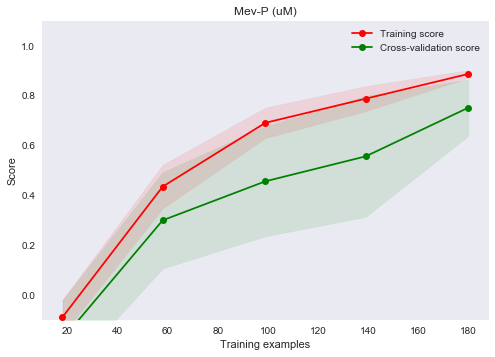

Average Training Score: 0.488308177003 n: 6


In [9]:
#1. Calculate Learning Curves for Derivatives

#Pick number of strains so that the total number is equal to max tested strains...
if data_type == 'simulated':
    strains = tsdf.index.get_level_values(0).unique()
    tsdf_max_strains = tsdf.loc[slice(strains[0],strains[max(strain_numbers)]),slice(None)]
else:
    tsdf_max_strains = tsdf

average_training_score = 0
n = 0
for target_index in tsdf_max_strains.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print(target)


    feature_indecies = [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[feature_indecies].values.tolist()
    y = tsdf_max_strains[target_index].values.tolist()

    #if fit_log_targets:
    #    y = [math.log(val) for val in y]
    
    #print(X)
    #print(y)
    if model_str == 'tpot':
        modelDict[target] = clone(mlmodel).fit(np.array(X),np.array(y)).fitted_pipeline_
        try:
            crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
        except:
            pass
    else:
        modelDict[target] = clone(mlmodel)
        crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
    
    ax = plt.gca()
    ax.set_ylim([-0.1, 1.1])
    strip_target = ''.join([char for char in target if char != '/'])
    print(strip_target)
    crossValPlot.savefig('figures/' + strip_target + 'CrossValPlot.pdf',transparent=False)
    plt.show()
    
    #Save out Cross Validation Plot
    
    modelDict[target] = modelDict[target].fit(X,y)
    average_training_score +=  modelDict[target].score(X,y)
    #print(modelDict[target_name].predict([reduced_features[2]]))
    
average_training_score /= n
print('Average Training Score:',average_training_score,'n:',n)

Total Time Series in Data Set:  1


feature                                            \
                  ATP (uM) Acetate g/L Acetyl-CoA (uM)          AtoB   
Strain Time (h)                                                        
L2     0.000000   0.302952    0.303717        0.286359  1.249415e+06   
       0.727273   0.288104    0.412069        0.293084  3.175036e+06   
       1.454545   0.273255    0.494135        0.299808  5.082022e+06   
       2.181818   0.258406    0.549913        0.306533  6.970373e+06   
       2.909091   0.243558    0.581022        0.313258  8.873632e+06   
       3.636364   0.228709    0.579706        0.319983  1.070980e+07   
       4.363636   0.212950    0.555286        0.327633  1.244907e+07   
       5.090909   0.198253    0.520314        0.334204  1.409144e+07   
       5.818182   0.186741    0.473192        0.337533  1.566671e+07   
       6.545455   0.179324    0.422059        0.336694  1.738527e+07   
       7.272727   0.175698    0.374880        0.331997  1.889264e+07   
       8.000000   0.174348    0.331686        0.324985  1.994779e+07   
       8.727273   0.172542    0.293871        0.318435  2.047537e+07   
       9.454545   0.170433    0.263639        0.312194  2.055074e+07   
       10.181818  0.168325    0.239559        0.305954  2.041544e+07   
       10.909091  0.166216    0.218725        0.299713  2.042315e+07   
       11.636364  0.164107    0.204083        0.293472  2.036141e+07   
       12.363636  0.161998    0.194408        0.287232  2.019934e+07   
       13.090909  0.159889    0.187484        0.280991  1.993694e+07   
       13.818182  0.157780    0.183172        0.274750  1.960509e+07   
       14.545455  0.155671    0.178161        0.268510  1.926551e+07   
       15.272727  0.153562    0.174053        0.262269  1.894138e+07   
       16.000000  0.151367    0.172980        0.255983  1.860296e+07   
       16.727273  0.149041    0.175467        0.249629  1.824312e+07   
       17.454545  0.147366    0.180439        0.243615  1.799038e+07   
       18.181818  0.146774    0.186073        0.238166  1.791616e+07   
       18.909091  0.147354    0.189850        0.233329  1.803472e+07   
       19.636364  0.148843    0.193006        0.228967  1.830323e+07   
       20.363636  0.150636    0.196018        0.224764  1.862173e+07   
       21.090909  0.152169    0.199309        0.220424  1.889738e+07   
...                    ...         ...             ...           ...   
       50.909091  0.129172    0.429059        0.117316  1.685195e+07   
       51.636364  0.128200    0.434889        0.116082  1.680055e+07   
       52.363636  0.127228    0.440719        0.114849  1.674914e+07   
       53.090909  0.126255    0.446549        0.113615  1.669774e+07   
       53.818182  0.125283    0.452379        0.112382  1.664633e+07   
       54.545455  0.124311    0.458209        0.111148  1.659493e+07   
       55.272727  0.123339    0.464039        0.109915  1.654352e+07   
       56.000000  0.122367    0.469869        0.108682  1.649212e+07   
       56.727273  0.121394    0.475699        0.107448  1.644071e+07   
       57.454545  0.120422    0.481529        0.106215  1.638931e+07   
       58.181818  0.119450    0.487359        0.104981  1.633790e+07   
       58.909091  0.118478    0.493189        0.103748  1.628650e+07   
       59.636364  0.117505    0.499019        0.102514  1.623509e+07   
       60.363636  0.116533    0.504850        0.101281  1.618369e+07   
       61.090909  0.115561    0.510680        0.100047  1.613228e+07   
       61.818182  0.114589    0.516510        0.098814  1.608088e+07   
       62.545455  0.113617    0.522340        0.097580  1.602947e+07   
       63.272727  0.112644    0.528170        0.096347  1.597807e+07   
       64.000000  0.111672    0.534000        0.095113  1.592666e+07   
       64.727273  0.110700    0.539830        0.093880  1.587526e+07   
       65.454545  0.109728    0.545660        0.092647  1.582385e+07   
       66.181818  0.108756    0.551490        0.091413  1.5

Acetyl-CoA (uM) Mean Error: -0.881491046611 Error Standard Deviation: 0.214991743726


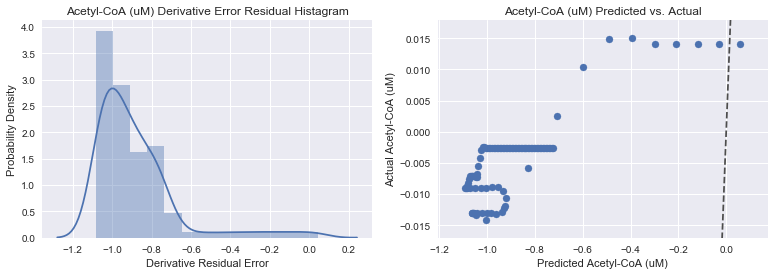

HMG-CoA (uM) Mean Error: -2.38167878788e-05 Error Standard Deviation: 0.00310934465661


/Users/zakcostello/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


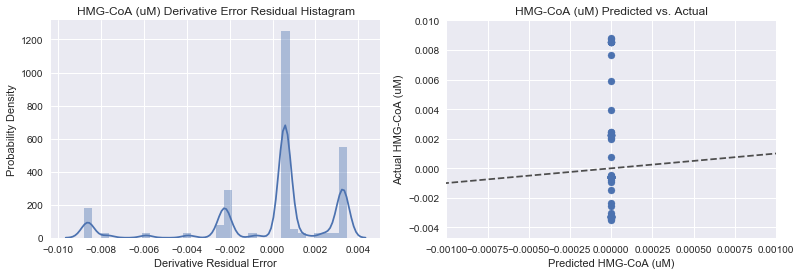

IPP/DMAPP (uM) Mean Error: 0.0856413854016 Error Standard Deviation: 0.0229244033383


/Users/zakcostello/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0843005579931, right=0.0843005579931
  'left=%s, right=%s') % (left, right))


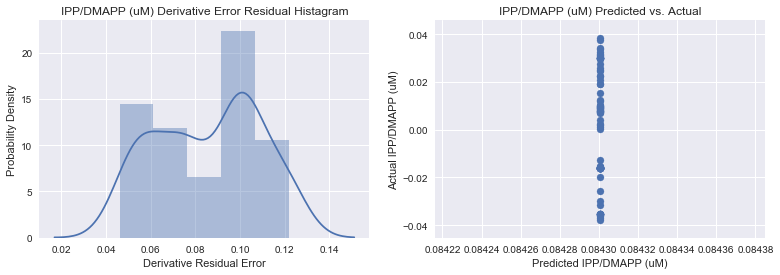

Intracellular Mevalonate (uM) Mean Error: 0.95326624746 Error Standard Deviation: 0.507250965327


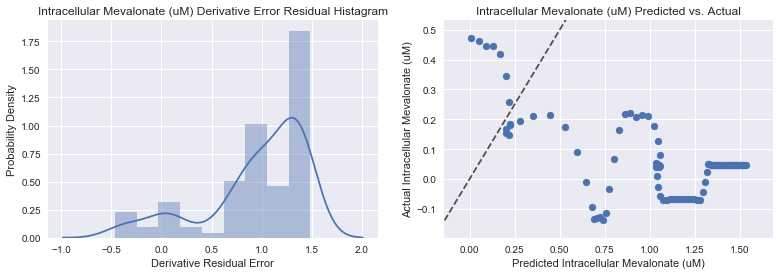

Limonene g/L Mean Error: 0.000311072556645 Error Standard Deviation: 0.00126062252418


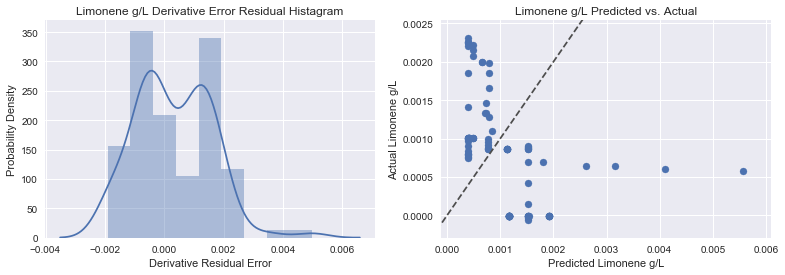

Mev-P (uM) Mean Error: -0.0589811166529 Error Standard Deviation: 0.0937493078648


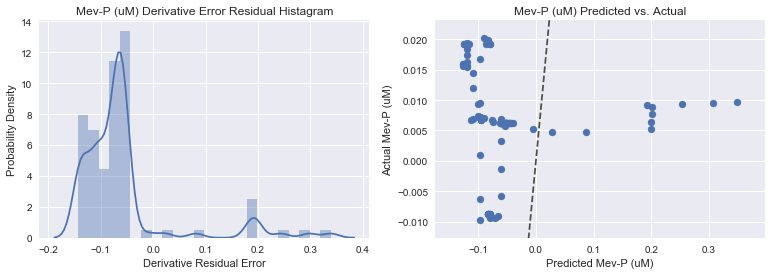

Total Derivative Mean Error: 1.37999900233 Error Standard Deviation: 0.324052131009


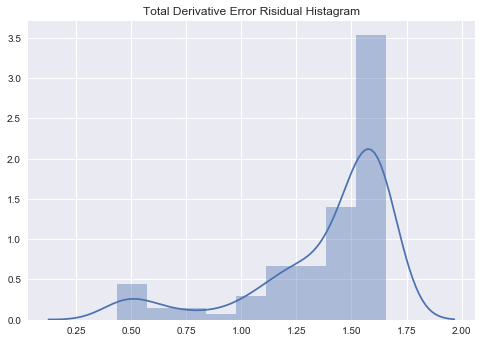

In [10]:
#2. Calculate Error Distribution and Plot + Report Moments
ts_test_df = generateTSDataSet(test_df,features,targets)
display(ts_test_df)
errors = []
for target in modelDict:
    times,y_test = remove_NaN(ts_test_df.reset_index()['Time (h)'].values,ts_test_df[('target',target)].values)
    
    feature_list = [('feature',feature) for feature in specific_features[target]]
    target_df = ts_test_df[feature_list]
    target_df = target_df[ts_test_df.index.get_level_values('Time (h)').isin(times)]
    
    #Check to make sure there are no NaNs in each feature
    for feature in target_df.columns:
        if any([math.isnan(val) for val in target_df[feature].values]):
            X,y = remove_NaN(target_df.reset_index()['Time'].values,target_df[feature].values)
            fnc = interp1d(X,y)
        index = 0
        for time,val in zip(times,target_df[feature].values):
            if math.isnan(val):
                #print(feature,time,fnc(time))
                target_df[feature].iloc[index] = fnc(time)
            index += 1
    #display(target_df)
    
    y_prediction = modelDict[target].predict(target_df.values)
    
    #print(y_prediction)
    #print(y_test)
    log_error = [math.log(max(y_p,0.0001)) - math.log(max(y_t,0.0001)) for y_p,y_t in zip(y_prediction,y_test)]
    error = [y_p - y_t for y_p,y_t in zip(y_prediction,y_test)]
    errors.append(error)
    
    mu = np.mean(error)
    sigma = np.std(error)
    print(target,'Mean Error:',mu,'Error Standard Deviation:',sigma)
    
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    sns.distplot(error)
    plt.title(target + ' Derivative '+ 'Error Residual Histagram')
    plt.xlabel('Derivative Residual Error')
    plt.ylabel('Probability Density')
    
    plt.subplot(122)
    plot_model_fit(target,y_prediction,y_test)
    
    strip_target = ''.join([char for char in target if char != '/'])
    plt.savefig('figures/' + strip_target + 'ErrorResiduals.pdf')
    plt.show()
    
    #modelDict[target].predict()

#Compute Net Error Magnitude
error_magnitude = [0]*len(errors[0])
for error in errors:
    error_magnitude = [em + e**2 for em,e in zip(error_magnitude,error)]
error_magnitude = [math.sqrt(e) for e in error_magnitude]
mu = np.mean(error_magnitude)
sigma = np.std(error_magnitude)
print('Total Derivative','Mean Error:',mu,'Error Standard Deviation:',sigma)
    
sns.distplot(error_magnitude)
plt.title('Total Derivative Error Risidual Histagram')
plt.show()

In [11]:
# If Experimental Limonene Results show that the Hand created 
# Kinetic Model Does not fit as well as the machine learning model

def proteomicsData(t,k):
    e = []
    for i in range(int(len(k)/3)):
        #Sorting the gains to ensure proteins only increase
        gains = sorted(k[3*i:3*(i+1)],reverse=True)
        e.append(leaky_hill_fcn(t,*gains)) 
    return e


def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
def solve_kinetic_ode(f,y0,times,k_fit):
    sol = 1
    return sol

measured_substrates = ['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Limonene g/L']
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
x_features = [('feature',val) for val in measured_enzymes+measured_substrates]
y_targets = [('target',val) for val in measured_substrates]

#print(x_features)
#print(y_targets)

if data_type == 'experimental' and  pathway == 'limonene':
    [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[x_features].values.tolist()
    y = tsdf_max_strains[y_targets].values.tolist()
    
    #Solve for Kinetic Coefficients from Training Set
    def cost_fcn_gen(X,y):
        def cost_fcn(free_params):
            cost = 0
            for x_val,y_vals in zip(X,y):
                params = []
                params.extend(x_val[0:6])       # AtoB to PMD Values
                params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
                params.extend(x_val[6:8])       # LS and Acetyl-CoA
                params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
                params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
                params.append(free_params[3])   #MevPP 
                params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
                params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
                params.extend(free_params[5:])  # Remaining Kinetic Free Parameters
                
                mp = kinetic_model(*params)
                prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
                cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
            return cost
        return cost_fcn

    cost_fcn = cost_fcn_gen(X,y)
    
    #Call to check its working (num free params = 39)
    print(cost_fcn([1,]*39))
    
    #Solve For Optimal Parameters
    bounds = [(1*10**-12,10**9)]*39
    sol = differential_evolution(cost_fcn,bounds,disp=True,maxiter=10000)
    best_params = sol.x
    print(best_params)

1.0633897204865148e+16
differential_evolution step 1: f(x)= 7.84561e+27
differential_evolution step 2: f(x)= 7.84561e+27
differential_evolution step 3: f(x)= 7.84561e+27
differential_evolution step 4: f(x)= 2.7018e+27
differential_evolution step 5: f(x)= 2.7018e+27
differential_evolution step 6: f(x)= 1.81261e+26
differential_evolution step 7: f(x)= 1.81261e+26
differential_evolution step 8: f(x)= 1.81261e+26
differential_evolution step 9: f(x)= 1.81261e+26
differential_evolution step 10: f(x)= 1.81261e+26
differential_evolution step 11: f(x)= 1.81261e+26
differential_evolution step 12: f(x)= 1.81261e+26
differential_evolution step 13: f(x)= 1.81261e+26
differential_evolution step 14: f(x)= 1.81261e+26
differential_evolution step 15: f(x)= 7.71253e+25
differential_evolution step 16: f(x)= 1.88109e+25
differential_evolution step 17: f(x)= 1.88109e+25
differential_evolution step 18: f(x)= 6.75556e+24
differential_evolution step 19: f(x)= 1.29253e+24
differential_evolution step 20: f(x)= 

differential_evolution step 164: f(x)= 1.26025e+15
differential_evolution step 165: f(x)= 1.26025e+15
differential_evolution step 166: f(x)= 1.26025e+15
differential_evolution step 167: f(x)= 1.26025e+15
differential_evolution step 168: f(x)= 1.26025e+15
differential_evolution step 169: f(x)= 1.26025e+15
differential_evolution step 170: f(x)= 1.26025e+15
differential_evolution step 171: f(x)= 1.26025e+15
differential_evolution step 172: f(x)= 1.26025e+15
differential_evolution step 173: f(x)= 1.10944e+15
differential_evolution step 174: f(x)= 1.10944e+15
differential_evolution step 175: f(x)= 1.10944e+15
differential_evolution step 176: f(x)= 1.10944e+15
differential_evolution step 177: f(x)= 1.10944e+15
differential_evolution step 178: f(x)= 1.10944e+15
differential_evolution step 179: f(x)= 1.10944e+15
differential_evolution step 180: f(x)= 1.10944e+15
differential_evolution step 181: f(x)= 1.10944e+15
differential_evolution step 182: f(x)= 1.10944e+15
differential_evolution step 183

differential_evolution step 325: f(x)= 4.16838e+11
differential_evolution step 326: f(x)= 4.16838e+11
differential_evolution step 327: f(x)= 4.16838e+11
differential_evolution step 328: f(x)= 4.16838e+11
differential_evolution step 329: f(x)= 4.16838e+11
differential_evolution step 330: f(x)= 4.16838e+11
differential_evolution step 331: f(x)= 4.16838e+11
differential_evolution step 332: f(x)= 3.31538e+11
differential_evolution step 333: f(x)= 3.31538e+11
differential_evolution step 334: f(x)= 3.31538e+11
differential_evolution step 335: f(x)= 3.31538e+11
differential_evolution step 336: f(x)= 3.31538e+11
differential_evolution step 337: f(x)= 3.31538e+11
differential_evolution step 338: f(x)= 3.31538e+11
differential_evolution step 339: f(x)= 3.31538e+11
differential_evolution step 340: f(x)= 3.06859e+11
differential_evolution step 341: f(x)= 3.06859e+11
differential_evolution step 342: f(x)= 3.06859e+11
differential_evolution step 343: f(x)= 3.06859e+11
differential_evolution step 344

differential_evolution step 486: f(x)= 1.95172e+09
differential_evolution step 487: f(x)= 1.95172e+09
differential_evolution step 488: f(x)= 1.95172e+09
differential_evolution step 489: f(x)= 1.95172e+09
differential_evolution step 490: f(x)= 4.62951e+08
differential_evolution step 491: f(x)= 4.62951e+08
differential_evolution step 492: f(x)= 4.62951e+08
differential_evolution step 493: f(x)= 4.62951e+08
differential_evolution step 494: f(x)= 4.62951e+08
differential_evolution step 495: f(x)= 4.62951e+08
differential_evolution step 496: f(x)= 4.62951e+08
differential_evolution step 497: f(x)= 4.62951e+08
differential_evolution step 498: f(x)= 4.62951e+08
differential_evolution step 499: f(x)= 4.62951e+08
differential_evolution step 500: f(x)= 4.62951e+08
differential_evolution step 501: f(x)= 4.62951e+08
differential_evolution step 502: f(x)= 4.62951e+08
differential_evolution step 503: f(x)= 4.62951e+08
differential_evolution step 504: f(x)= 4.62951e+08
differential_evolution step 505

differential_evolution step 647: f(x)= 3.75892e+06
differential_evolution step 648: f(x)= 3.75892e+06
differential_evolution step 649: f(x)= 3.75892e+06
differential_evolution step 650: f(x)= 3.75892e+06
differential_evolution step 651: f(x)= 2.80949e+06
differential_evolution step 652: f(x)= 2.80949e+06
differential_evolution step 653: f(x)= 2.80949e+06
differential_evolution step 654: f(x)= 2.80949e+06
differential_evolution step 655: f(x)= 2.80949e+06
differential_evolution step 656: f(x)= 2.80949e+06
differential_evolution step 657: f(x)= 2.80949e+06
differential_evolution step 658: f(x)= 2.80949e+06
differential_evolution step 659: f(x)= 2.80949e+06
differential_evolution step 660: f(x)= 2.80949e+06
differential_evolution step 661: f(x)= 2.80949e+06
differential_evolution step 662: f(x)= 2.80949e+06
differential_evolution step 663: f(x)= 2.80949e+06
differential_evolution step 664: f(x)= 2.80949e+06
differential_evolution step 665: f(x)= 2.80949e+06
differential_evolution step 666

differential_evolution step 821: f(x)= 28338.3
differential_evolution step 822: f(x)= 28338.3
differential_evolution step 823: f(x)= 28338.3
differential_evolution step 824: f(x)= 28338.3
differential_evolution step 825: f(x)= 28338.3
differential_evolution step 826: f(x)= 28338.3
differential_evolution step 827: f(x)= 28338.3
differential_evolution step 828: f(x)= 28338.3
differential_evolution step 829: f(x)= 28338.3
differential_evolution step 830: f(x)= 28338.3
differential_evolution step 831: f(x)= 28338.3
differential_evolution step 832: f(x)= 28338.3
differential_evolution step 833: f(x)= 28338.3
differential_evolution step 834: f(x)= 28338.3
differential_evolution step 835: f(x)= 28338.3
differential_evolution step 836: f(x)= 24332.4
differential_evolution step 837: f(x)= 24332.4
differential_evolution step 838: f(x)= 24332.4
differential_evolution step 839: f(x)= 24319.9
differential_evolution step 840: f(x)= 24319.9
differential_evolution step 841: f(x)= 24319.9
differential_

differential_evolution step 997: f(x)= 93.9673
differential_evolution step 998: f(x)= 93.9673
differential_evolution step 999: f(x)= 93.9673
differential_evolution step 1000: f(x)= 93.9673
differential_evolution step 1001: f(x)= 93.9673
differential_evolution step 1002: f(x)= 93.9673
differential_evolution step 1003: f(x)= 93.9673
differential_evolution step 1004: f(x)= 93.9673
differential_evolution step 1005: f(x)= 93.9673
differential_evolution step 1006: f(x)= 93.9673
differential_evolution step 1007: f(x)= 93.9673
differential_evolution step 1008: f(x)= 93.9673
differential_evolution step 1009: f(x)= 93.9673
differential_evolution step 1010: f(x)= 93.9673
differential_evolution step 1011: f(x)= 93.9673
differential_evolution step 1012: f(x)= 79.7868
differential_evolution step 1013: f(x)= 72.0785
differential_evolution step 1014: f(x)= 72.0785
differential_evolution step 1015: f(x)= 72.0785
differential_evolution step 1016: f(x)= 72.0785
differential_evolution step 1017: f(x)= 72.

differential_evolution step 1168: f(x)= 33.7618
differential_evolution step 1169: f(x)= 33.4111
differential_evolution step 1170: f(x)= 33.4111
differential_evolution step 1171: f(x)= 33.4111
differential_evolution step 1172: f(x)= 33.4111
differential_evolution step 1173: f(x)= 33.4111
differential_evolution step 1174: f(x)= 33.4111
differential_evolution step 1175: f(x)= 33.4111
differential_evolution step 1176: f(x)= 33.4111
differential_evolution step 1177: f(x)= 33.4111
differential_evolution step 1178: f(x)= 33.4111
differential_evolution step 1179: f(x)= 33.4111
differential_evolution step 1180: f(x)= 33.4111
differential_evolution step 1181: f(x)= 33.4111
differential_evolution step 1182: f(x)= 33.4111
differential_evolution step 1183: f(x)= 33.4111
differential_evolution step 1184: f(x)= 33.4111
differential_evolution step 1185: f(x)= 33.4111
differential_evolution step 1186: f(x)= 33.4111
differential_evolution step 1187: f(x)= 33.4111
differential_evolution step 1188: f(x)= 

In [12]:
import statistics

def plot_species_curves(modelDict, title, df, targets, specific_features, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3),training_sets=5):
    """
    Generate a simple plot of the test and training learning curve. Returns Metrics for each predicted curve

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    #Set Random Seed For training
    seed = 103
    random.seed(seed)
    
    #Create figure / plots
    fig = plt.figure(figsize=(12,16))
    #fig.set_title(title)
    #if ylim is not None:
    #    plt.ylim(*ylim)
    
    #Create subplots for each target
    ax = {}
    for i,target in enumerate(targets):
        ax[target] = plt.subplot(int(len(targets)/2), 2, i+1)
    
    #Get Randomized List of all Strains
    strains = df.index.get_level_values(0).unique()
    strains = list(strains.values)
    #print(strains)
    strains = random.sample(strains, len(strains))
    
    #Pick test strain
    test_df = df.loc[(slice(strains[0],strains[0]),slice(None)),:]
    strains = strains[1:]
    
    #Create Interpolation functions for each feature in the test strain
    interpFun = {}
    #display(test_df.reset_index())
    for feature in df.columns:
        X,y = remove_NaN(test_df.reset_index()['Time (h)'].tolist(),test_df[feature].tolist())
        if isinstance(feature,tuple):
            if feature[0] == 'feature':
                feature = feature[1]
            else:
                continue

        interpFun[feature] = interp1d(X,y)  

    train_sizes = [int(len(strains)*size/training_sets)-1 for size in train_sizes]
    for i,size in enumerate(train_sizes):
        if size < 2:
            train_sizes[i] = 2
            
    #Create Fits for each training set
    fits = {}
    for training_set in range(training_sets):        
        fits[training_set] = {}

        #Generate training strain data for this training set
        training_strains = strains[0:(train_sizes[-1] + 1)]
        #print(training_strains)
        strains = strains[train_sizes[-1]:]
        endSamples = train_sizes
        #print('Strains:',strains)
        #print('End Samples',endSamples)
        sample_sets = [df.loc[(training_strains[0:endSample],slice(None)),:] for endSample in endSamples]

        #For each set size in the training set fit the model and store it
        for j,sample_set in enumerate(sample_sets):
            
            #print('Sample Set:',sample_set.index.get_level_values(0).unique().values)
            
            # Train Model
            print('Training Models for Training Set',training_set,'In Sample set',j)
            for target in targets:
                feature_indecies = [('feature', feature) for feature in specific_features[target]]
                X = sample_set[feature_indecies].values.tolist()

                #print(feature_indecies)
                #display(sample_set[feature_indecies])
                target_index = ('target',target)
                y = sample_set[target_index].values.tolist()
                modelDict[target].fit(X,y)

            print('Integrating ODEs!')
            # Integrate Given Model Test Case
            g = mlode(modelDict, test_df, targets, specific_features)
            times = test_df.reset_index()['Time (h)'].tolist()

            #Set Y0 initial condition
            appended_targets = [('feature',target) for target in targets]
            #display(test_df)
            #display(test_df[appended_targets].iloc[0])
            y0 = test_df[appended_targets].iloc[0].tolist()

            #print('times:',times)
            fit  = odeintz(g,y0,times)
            fitT = list(map(list, zip(*fit)))
            fits[training_set][train_sizes[j]] = fitT

    
    #Perform Statistics on Fits and generate plots
    colors = ['b','g','k','y','m']
    predictions = {}
    lines =[]
    labels = []
    for k,target in enumerate(targets):
        actual_data = [interpFun[target](t) for t in times]
        predictions[target] = {'actual':actual_data}
        predictions['Time'] = times
        if k == 0:
            lines.append(ax[target].plot(times,actual_data,'--', color='r')[0])
            labels.append('Actual Dynamics')
        else:
            ax[target].plot(times,actual_data,'--', color='r')
        ax[target].set_title(target)
        
        for j in range(len(sample_sets)):
            upper = []
            lower = []
            aves = []
            
            predictions[target][train_sizes[j]] = []
            for training_set in range(training_sets):
                predictions[target][train_sizes[j]].append(fits[training_set][train_sizes[j]][k])
            
            for i,time in enumerate(times):
                
                values = []
                for training_set in range(training_sets):
                    #print(training_set,train_sizes[j],i)
                    values.append(fits[training_set][train_sizes[j]][k][i])

                #Compute Statistics of Values
                #print(values)
                ave = statistics.mean(values)
                std = statistics.stdev(values)
                aves += [ave,]
                upper += [ave + std,]
                lower += [ave - std,]
                
                #print(upper)
                #print(times)
                
            #Compute upper and lower bounds for shading
            ax[target].fill_between(times, lower,upper, alpha=0.1, color=colors[j])
            if k == 0:
                lines.append(ax[target].plot(times,aves,colors[j])[0])
                labels.append(str(train_sizes[j]) + ' Strain Prediction')
            else:
                ax[target].plot(times,aves,colors[j])
            print(colors[j],train_sizes[j])
        plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )       

    return predictions

y0 [0.286359015, 0.007628361, 0.892762772, 0.046703445, 0.173320815, 0.0]
['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Limonene g/L']


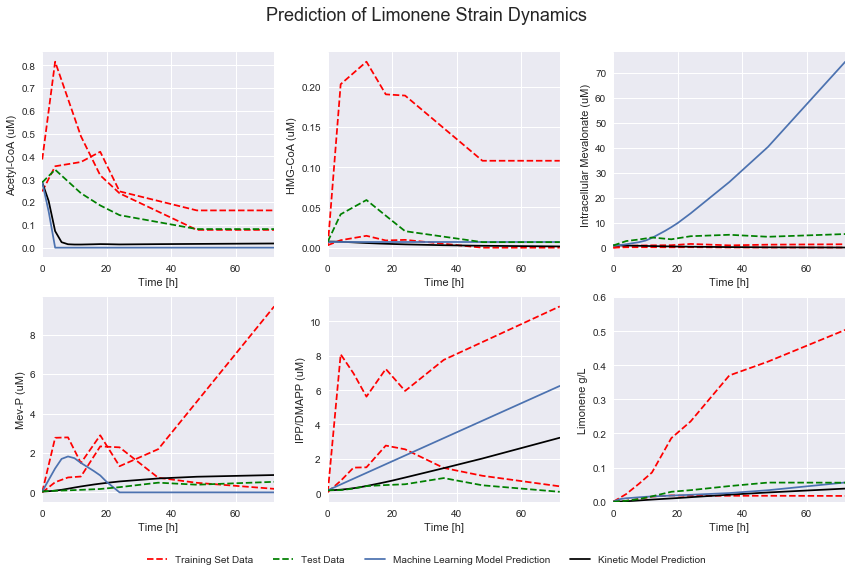

In [13]:
#3. Plot Comparison between Actual and Predicted Results
if data_type == 'simulated':
    real_vs_predicted = plot_species_curves(modelDict, 'title', tsdf, targets, specific_features,train_sizes=train_sizes,training_sets=training_sets)
    plt.savefig('figures/MainFigure.pdf')
    
    
elif data_type == 'experimental':
    #Fit each test strain by solving the differential equation

    #Select Random Time Series
    #test_df = df
    #display(test_df)
    strains = test_df.index.get_level_values(0).unique()
    #print(strains)

    random_strain = random.sample(tuple(strains), 1)
    #print(random_strain)

    random_strain = list(random_strain)[0]
    #random_strain = 180
    random_df = test_df.loc[(slice(random_strain,random_strain),slice(None)),:]
    #print('The Chosen Random Strain is:', random_strain)

    #Set Y0 initial condition
    y0 = random_df[targets].iloc[0].tolist()
    print('y0',y0)
    
    #Create Differential Equation to Solve
    #print('Creating Differential Equation!')
    if featureReduction:
        target_features = [header[1:]]*len(targets[0])
        g = mlode(modelDict, random_df, targets, specific_features)
    else:
        g = mlode(modelDict, random_df, targets, specific_features,time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    #print('Solving Differential Equation')
    times = random_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    
    #Create Interpolation functions for each feature
    interpFun = {}
    for feature in random_df.columns:
        X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
        interpFun[feature] = interp1d(X,y)

        
    if pathway == 'limonene':
        #print(random_df.columns)
        proteins = ['AtoB', 'HMGR', 'HMGS', 'MK', 'PMD', 'PMK','Limonene Synthase']
        protein_fcns= []
        for feature in random_df.columns:
            X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
            protein_fcns.append(interp1d(X,y))
        
        #Generate Fit Kinetic Model ODE
        def kinetic_ode(x,t,proteomic_fcns):
            
            #proteomics 
            proteomic_data = [proteomic_fcn(t) for proteomic_fcn in proteomic_fcns]

            params = []
            params.extend(proteomic_data[0:6]) # AtoB to PMD Values
            params.extend(best_params[0:2])     # Keep Constant GPPS and IDI levels as free parameters
            params.append(proteomic_data[6])   # 
            params.append(x[0])                #Acetyl-CoA
            params.append(best_params[2])       # AcetoAcetyl-CoA as a free Param
            params.extend(x[1:4])               # HMG-CoA & Mev & MevP measured
            params.append(best_params[3])       # MevPP 
            params.extend([x[4],x[4]])          # DMAPP & IDI Measured
            params.extend([best_params[4],x[5]]) # GPP as a Free Parameter #Measured Limonene Synthase
            params.extend(best_params[5:])      # Remaining Kinetic Free Parameters
            
            
            dxdt = kinetic_model(*params)
            dxdt_combined = [dxdt[0],dxdt[2],dxdt[3],dxdt[4],dxdt[6]+dxdt[7],dxdt[9]]
            return dxdt_combined
        
        for protein in proteins:
            protein_fcns.append(interpFun[protein])
        
        #Solve Kinetic ODE at initial Conditions
        kinetic_ode_p = lambda x,t : kinetic_ode(x,t,protein_fcns)
        kinetic_fit = odeintz(kinetic_ode_p,y0,times)
        kinetic_fit = list(map(list, zip(*kinetic_fit)))
        
    real_vs_predicted = {}
    plt.figure(figsize=(12,8))
    for i,target in enumerate(targets):
        plt.subplot(2,3,i+1)
        if data_type == 'experimental':
            #Plot both High and Low Strain values
            for strain in training_strains:
                strainInterpFun = {}
                strain_df = df.loc[(strain,slice(None))]
                X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
                strainInterpFun[target] = interp1d(X,y)
                actual_data = [strainInterpFun[target](t) for t in times]
                train_line, = plt.plot(times,actual_data,'r--')
            
            #Plot Kinetic Model Fit
            if pathway =='limonene':
                kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times)]
                kinetic_line, = plt.plot(times,kinetic_pred,color='k')

        actual_data = [interpFun[target](t) for t in times]
        pos_pred = [max(fitT[i][j],0) for j,t in enumerate(times)]
        prediction_line, = plt.plot(times,pos_pred)
        #print(actual_data)
        test_line, = plt.plot(times,actual_data,'g--')
        plt.ylabel(target)
        plt.xlabel('Time [h]')
        plt.xlim([0,72])
        
        if i == 5 and pathway == 'limonene':
            plt.ylim([0,0.6])
        
        #Create variable for processing error residuals
        if pathway == 'limonene':
            real_vs_predicted[target] = [times,actual_data,pos_pred,kinetic_pred]
        else:
            real_vs_predicted[target] = [times,actual_data,pos_pred]
    #Add Legend
    if set_num==2:
        product = 'Isopentenol'
    elif set_num==3:
        product = 'Limonene'
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.subplots_adjust(bottom=0.12)
    plt.suptitle('Prediction of ' + product + ' Strain Dynamics', fontsize=18)
    if pathway == 'limonene':
        plt.figlegend( (train_line,test_line,prediction_line,kinetic_line), ('Training Set Data','Test Data','Machine Learning Model Prediction','Kinetic Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. )  
    else:
        plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
    plt.savefig('data/' + product + '_prediction.eps', format='eps', dpi=600)
    plt.show()

In [14]:
#4. Error Residuals of Time Series Data + Key Moments Report

#Not Quite Right... Need to Integrate over the 
if data_type == 'experimental':
    #print(real_vs_predicted)

    rmse_percent = []
    rmse_average = []
    rmse_percent_k = []
    rmse_average_k = []
    for metabolite in real_vs_predicted:
        if pathway == 'limonene':
            times,real,predicted,kinetic = real_vs_predicted[metabolite]
        else:
            times,real,predicted = real_vs_predicted[metabolite]
        real_fcn = interp1d(times,real)
        pred_fcn = interp1d(times,predicted)

        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
        rmse = math.sqrt(quad(integrand,min(times),max(times))[0])
        rmse_average.append(rmse)
        percent_integrand = lambda t: abs(real_fcn(t) - pred_fcn(t))/(real_fcn(t)*max(times))
        #print(metabolite,[percent_integrand(t) for t in times],[real_fcn(t) for t in times],[pred_fcn(t) for t in times])
        
        rmsep = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
        rmse_percent.append(rmsep)
        print('ML Fit:',metabolite,rmse,'RMSE percent:',rmsep*100)
        
        if pathway == 'limonene':
            kinetic_fcn = interp1d(times,kinetic)
            integrand = lambda t: (real_fcn(t) - kinetic_fcn(t))**2
            rmsek = math.sqrt(quad(integrand,min(times),max(times))[0])
            percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
            rmsepk = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
            rmse_percent_k.append(rmsepk)
            rmse_average_k.append(rmsek)
            print('Kinetic Fit:',metabolite,rmsek,'RMSE percent:',rmsepk*100)
    
    print('')
    print('Machine Learning Model Agrigate Error')
    print('Average RMSE:',sum(rmse_average)/len(rmse_average))
    print('Total Percent Error:',sum(rmse_percent)/len(rmse_percent)*100)

    if pathway == 'limonene':
        print('')
        print('Kinetic Model Agrigate Error')
        print('Average RMSE:',sum(rmse_average_k)/len(rmse_average_k))
        print('Total Percent Error:',sum(rmse_percent_k)/len(rmse_percent_k)*100)
        
elif data_type == 'simulated':
    times = real_vs_predicted['Time']
    rmse_dict = {}
    for metabolite in real_vs_predicted:
        if metabolite not in ['Time',]:
            actual = real_vs_predicted[metabolite]['actual']
            real_fcn = interp1d(times,actual)
            rmse_dict[metabolite] = {}
            for test_size in real_vs_predicted[metabolite]:
                print(metabolite,'Test Size:',test_size)
                total_rmse = []
                if test_size not in ['Time','actual']:
                    #For Each Test Size Produce Values + Moments Reporting...
                    rmse = []
                    for test_strain in enumerate(real_vs_predicted[metabolite][test_size]):
                        #print(test_strain)
                        pred_fcn = interp1d(times,test_strain[1])
                        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
                        rmse.append(math.sqrt(quad(integrand,min(times),max(times))[0]))
                        
                    #Report Moments for each Test Size
                    rmse_dict[metabolite][test_size] = rmse
                    print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
                    print('RMSEs:',rmse)
                    print('')
                    

    #Calculate Mean Total Error + Mean Standard Deviation for Composite Error
    size_dict = {}
    for metabolite in rmse_dict:
        for test_size in rmse_dict[metabolite]:
            size_dict[test_size] = [0]*len(rmse_dict[metabolite][test_size])
            size_dict[test_size] = [s + r for s,r in zip(rmse_dict[metabolite][test_size],size_dict[test_size])]

    #Print out Agrigate Statistics
    for test_size in size_dict:
        rmse = size_dict[test_size]
        print('Test Size for Agrigate Statistics:',test_size)
        print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
        print('RMSEs:',rmse)
        print('')
        
        
    

ML Fit: Acetyl-CoA (uM) 1.314951630566375 RMSE percent: 98.61732838805818


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Kinetic Fit: Acetyl-CoA (uM) 1.1638534445661914 RMSE percent: 90.80247967961212
ML Fit: HMG-CoA (uM) 0.17762995146575597 RMSE percent: 65.49967689140145
Kinetic Fit: HMG-CoA (uM) 0.19155872953101122 RMSE percent: 87.60900661689838
ML Fit: Intracellular Mevalonate (uM) 285.6249757349928 RMSE percent: 230.28896859279251
Kinetic Fit: Intracellular Mevalonate (uM) 35.42902131467681 RMSE percent: 94.70310289489558
ML Fit: Mev-P (uM) 6.136026197119371 RMSE percent: 186.4893328478977
Kinetic Fit: Mev-P (uM) 2.486155341372301 RMSE percent: 90.95595229978346
ML Fit: IPP/DMAPP (uM) 28.007640268414228 RMSE percent: 315.2036614157078
Kinetic Fit: IPP/DMAPP (uM) 12.486943186272855 RMSE percent: 208.46166938543038
ML Fit: Limonene g/L 0.12029211367562681 RMSE percent: 76.62843994487179
Kinetic Fit: Limonene g/L 0.17974218628087313 RMSE percent: 72.23336278749613

Machine Learning Model Agrigate Error
Average RMSE: 53.56358598270569
Total Percent Error: 162.12123468012157

Kinetic Model Agrigate Erro

In [15]:
if data_type == 'simulated':
    
    
    #Plot Agrigate Statistics in the form of a bar graph...
    sizes = list(size_dict.keys())
    means = [np.mean(size_dict[size]) for size in sizes]
    stdevs = [np.std(size_dict[size]) for size in sizes]
    y_pos = np.arange(len(sizes))

    #Calculate Percent Errors              
    #for size in sizes:
    #    for training_set in training_sets:
    #        percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
    
    
    plt.bar(y_pos, means, align='center',yerr=stdevs)
    plt.xticks(y_pos, sizes)
    plt.ylabel('RMSE')
    plt.xlabel('Training Set Size')
    plt.title('RMSE vs Training Set Size')
    plt.savefig('figures/RMSEvsSize.pdf')
    
    plt.show()